# H5A4 Fixed Income Analysis

Analysis of H5A4 data with trading days only (weekends and holidays removed).

**Data:** H5A4_Data_cleaned.csv (cleaned data with correct date alignment)

## Imports

In [560]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Trading engine (available in Docker)
try:
    from trading_engine.core import read_data, create_model_state
    print("âœ“ Trading engine imported successfully")
    DOCKER_MODE = True
except ImportError:
    print("âš  Trading engine not available (not running in Docker)")
    DOCKER_MODE = False

âœ“ Trading engine imported successfully


## Load H5A4 Data

In [561]:
# Load H5A4 data from Price History CSV
data_path = 'MLH5A4_Price_History(Fixed Income).csv'

# Read CSV - skip first 14 rows, then use first row as header
df_raw = pd.read_csv(data_path, skiprows=14)
df_raw.columns = df_raw.iloc[0]
df_raw = df_raw.drop(0).reset_index(drop=True)

# Extract Date and Price columns
df = df_raw[['Date', 'Price']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.set_index('Date')
df = df.rename(columns={'Price': 'H5A4'})

# Remove any NaN values
df = df.dropna()

# Presentation start date (for display purposes only)
PRESENTATION_START_DATE = '1997-12-11'

print(f"H5A4 Data Loaded!")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(df)}")
print(f"Presentation starts from: {PRESENTATION_START_DATE}")
print(f"\nFirst few rows (for presentation):")
df[df.index >= PRESENTATION_START_DATE].head(10)

H5A4 Data Loaded!
Shape: (7263, 1)
Date range: 1996-12-31 to 2025-11-11
Total trading days: 7263
Presentation starts from: 1997-12-11

First few rows (for presentation):


,H5A4
Date,
1997-12-11,101.66
1997-12-12,101.72
1997-12-15,101.67
1997-12-16,101.68
1997-12-17,101.61
1997-12-18,101.65
1997-12-19,101.67
1997-12-22,101.61
1997-12-23,101.54


In [562]:
# Verify datetime format
print("Data Type Information:")
print("="*60)
print(f"Index type: {type(df.index)}")
print(f"Index dtype: {df.index.dtype}")
print(f"Is DatetimeIndex: {isinstance(df.index, pd.DatetimeIndex)}")
print(f"\nIndex range:")
print(f"  First: {df.index[0]} ({df.index[0].strftime('%A, %B %d, %Y')})")
print(f"  Last:  {df.index[-1]} ({df.index[-1].strftime('%A, %B %d, %Y')})")
print(f"\nSample dates:")
for i in [0, 100, 500, -1]:
    date = df.index[i]
    print(f"  {date} - {date.strftime('%A')}")

Data Type Information:
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index dtype: datetime64[ns]
Is DatetimeIndex: True

Index range:
  First: 1996-12-31 00:00:00 (Tuesday, December 31, 1996)
  Last:  2025-11-11 00:00:00 (Tuesday, November 11, 2025)

Sample dates:
  1996-12-31 00:00:00 - Tuesday
  1997-05-23 00:00:00 - Friday
  1998-12-23 00:00:00 - Wednesday
  2025-11-11 00:00:00 - Tuesday


## Summary Statistics

In [563]:
# Calculate summary statistics
print("H5A4 Summary Statistics:")
print("="*60)
print(df.describe())

# Calculate daily returns
df['daily_return'] = df['H5A4'].pct_change()
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1

# Calculate multi-period returns
df['return_10d'] = df['H5A4'].pct_change(10)
df['return_20d'] = df['H5A4'].pct_change(20)
df['return_60d'] = df['H5A4'].pct_change(60)
df['return_120d'] = df['H5A4'].pct_change(120)
df['return_240d'] = df['H5A4'].pct_change(240)

print("\nDaily Returns Summary:")
print("="*60)
print(f"Total Return: {df['cumulative_return'].iloc[-1]:.2%}")
print(f"Annualized Return: {(1 + df['cumulative_return'].iloc[-1]) ** (252 / len(df)) - 1:.2%}")
print(f"Annualized Volatility: {df['daily_return'].std() * np.sqrt(252):.2%}")

H5A4 Summary Statistics:
0             H5A4
count  7263.000000
mean     98.157800
std       7.057188
min      62.830000
25%      94.140000
50%     100.030000
75%     103.140000
max     109.260000

Daily Returns Summary:
Total Return: -0.10%
Annualized Return: -0.00%
Annualized Volatility: 5.07%


## Momentum Signals

Generate trading signals based on momentum (1 if positive, 0 if negative)

In [564]:
# Generate momentum signals for each time frame
# Rule: signal = 1 if returns > 0, signal = 0 if returns <= 0

df['signal_10d'] = (df['return_10d'] > 0).astype(int)
df['signal_20d'] = (df['return_20d'] > 0).astype(int)
df['signal_60d'] = (df['return_60d'] > 0).astype(int)
df['signal_120d'] = (df['return_120d'] > 0).astype(int)
df['signal_240d'] = (df['return_240d'] > 0).astype(int)

# Create combined signals dataframe
signals_df = df[['H5A4', 'return_10d', 'signal_10d', 'return_20d', 'signal_20d', 
                  'return_60d', 'signal_60d', 'return_120d', 'signal_120d', 
                  'return_240d', 'signal_240d']].copy()

print("\nCombined Signals DataFrame:")
print(f"Full shape: {signals_df.shape}")
print(f"Presentation period (from {PRESENTATION_START_DATE}): {signals_df[signals_df.index >= PRESENTATION_START_DATE].shape}")
print("\nLast 10 rows:")
signals_df.tail(10)


Combined Signals DataFrame:
Full shape: (7263, 11)
Presentation period (from 1997-12-11): (7023, 11)

Last 10 rows:


,H5A4,return_10d,signal_10d,return_20d,signal_20d,return_60d,signal_60d,return_120d,signal_120d,return_240d,signal_240d
Date,,,,,,,,,,,
2025-10-29,100.30,0.002599,1,-0.000697,0,0.009359,1,0.032105,1,0.023261,1
2025-10-30,100.08,0.000900,1,-0.003187,0,0.006740,1,0.030054,1,0.020704,1
2025-10-31,100.07,0.001601,1,-0.002890,0,0.006538,1,0.023629,1,0.021122,1
2025-11-03,99.88,-0.001599,0,-0.004684,0,0.005031,1,0.019496,1,0.022209,1
2025-11-04,99.68,-0.004096,0,-0.005785,0,0.003120,1,0.019119,1,0.019744,1
2025-11-05,99.74,-0.002899,0,-0.004392,0,0.002916,1,0.020776,1,0.018899,1
2025-11-06,99.70,-0.003498,0,-0.001802,0,0.000602,1,0.019323,1,0.018698,1
2025-11-07,99.64,-0.005986,0,0.001608,1,0.001105,1,0.019439,1,0.017254,1
2025-11-10,99.89,-0.005179,0,0.004121,1,0.003920,1,0.021579,1,0.020014,1


In [565]:
# Create Blended Momentum (BMOM)
# BMOM = 0.15*mom20 + 0.35*mom60 + 0.35*mom120 + 0.15*mom240

w1 = 0.15  # weight for 20-day
w2 = 0.35  # weight for 60-day
w3 = 0.35  # weight for 120-day
w4 = 0.15  # weight for 240-day

# Calculate blended momentum
df['blended_mom'] = (w1 * df['return_20d'] + 
                     w2 * df['return_60d'] + 
                     w3 * df['return_120d'] + 
                     w4 * df['return_240d'])

# Generate blended signal
df['blended_signal'] = (df['blended_mom'] > 0).astype(int)

print("Blended Momentum Signal Created!")
print("="*60)
print(f"\nWeights:")
print(f"  20-day:  {w1:.2f}")
print(f"  60-day:  {w2:.2f}")
print(f"  120-day: {w3:.2f}")
print(f"  240-day: {w4:.2f}")
print(f"  Total:   {w1+w2+w3+w4:.2f}")

# Filter for presentation (from PRESENTATION_START_DATE onwards)
df_display = df[df.index >= PRESENTATION_START_DATE].copy()

# Signal distribution (presentation period)
total = df_display['blended_signal'].count()
long_count = df_display['blended_signal'].sum()
long_pct = (long_count / total) * 100
flat_count = total - long_count
flat_pct = (flat_count / total) * 100

print(f"\nBlended Signal Distribution (from {PRESENTATION_START_DATE}):")
print(f"  Long: {long_count:>4} ({long_pct:>5.1f}%)")
print(f"  Flat: {flat_count:>4} ({flat_pct:>5.1f}%)")

print(f"\nLatest Blended Momentum:")
print(f"  BMOM value: {df['blended_mom'].iloc[-1]:>8.4f}")
print(f"  Signal:     {df['blended_signal'].iloc[-1]}")

# Summary statistics (presentation period)
print(f"\nBlended Momentum Statistics (from {PRESENTATION_START_DATE}):")
print(f"  Mean:       {df_display['blended_mom'].mean():>8.4f}")
print(f"  Std Dev:    {df_display['blended_mom'].std():>8.4f}")
print(f"  Min:        {df_display['blended_mom'].min():>8.4f}")
print(f"  Max:        {df_display['blended_mom'].max():>8.4f}")

# Find first non-NaN BMOM date
first_valid_bmom = df['blended_mom'].first_valid_index()
print(f"\nFirst valid BMOM date: {first_valid_bmom.strftime('%Y-%m-%d')}")

# Show recent blended momentum values (from presentation start)
print(f"\nBlended Momentum & Signals (starting from {PRESENTATION_START_DATE}):")
print("-"*60)
recent = df_display[['H5A4', 'blended_mom', 'blended_signal']].head(30)
recent

Blended Momentum Signal Created!

Weights:
  20-day:  0.15
  60-day:  0.35
  120-day: 0.35
  240-day: 0.15
  Total:   1.00

Blended Signal Distribution (from 1997-12-11):
  Long: 3780 ( 53.8%)
  Flat: 3243 ( 46.2%)

Latest Blended Momentum:
  BMOM value:   0.0130
  Signal:     1

Blended Momentum Statistics (from 1997-12-11):
  Mean:         0.0014
  Std Dev:      0.0466
  Min:         -0.2857
  Max:          0.1939

First valid BMOM date: 1997-12-11

Blended Momentum & Signals (starting from 1997-12-11):
------------------------------------------------------------


,H5A4,blended_mom,blended_signal
Date,,,
1997-12-11,101.66,0.000927,1
1997-12-12,101.72,0.001689,1
1997-12-15,101.67,0.001192,1
1997-12-16,101.68,0.001881,1
1997-12-17,101.61,0.001421,1
1997-12-18,101.65,0.001969,1
1997-12-19,101.67,0.002102,1
1997-12-22,101.61,0.001381,1
1997-12-23,101.54,0.000317,1


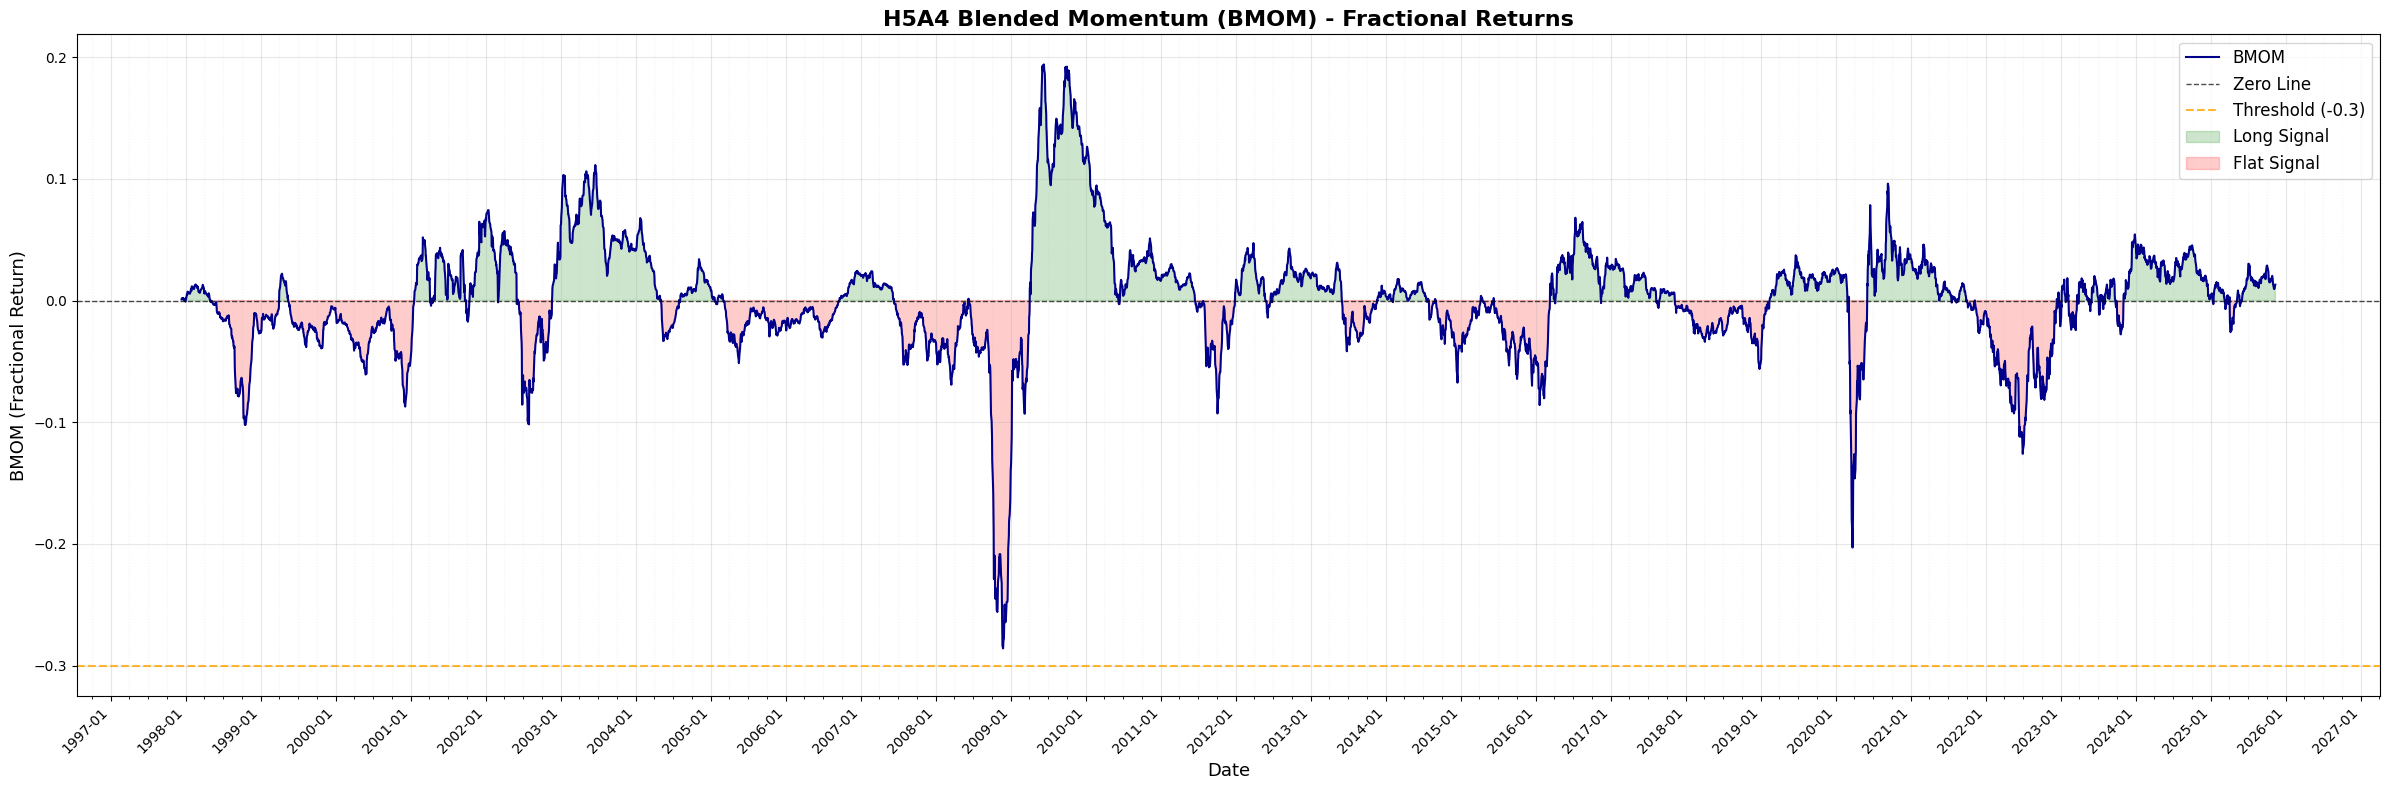


BMOM Range:
  Min: -0.2857 on 2008-11-24
  Max: 0.1939 on 2009-06-10
  Current: 0.0130


In [566]:
# Plot Blended Momentum (BMOM) as fractional returns
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(24, 8))

# Filter to presentation period
bmom_display = df[df.index >= PRESENTATION_START_DATE]['blended_mom'].copy()

# Plot BMOM
ax.plot(bmom_display.index, bmom_display, linewidth=1.5, color='darkblue', label='BMOM')

# Add zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.0, alpha=0.7, label='Zero Line')

# Add threshold line at -0.3
ax.axhline(y=-0.3, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label='Threshold (-0.3)')

# Shade positive/negative regions
ax.fill_between(bmom_display.index, 0, bmom_display, where=(bmom_display > 0), 
                 color='green', alpha=0.2, label='Long Signal')
ax.fill_between(bmom_display.index, 0, bmom_display, where=(bmom_display <= 0), 
                 color='red', alpha=0.2, label='Flat Signal')

# Format x-axis with more dates
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Major tick every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))  # Minor ticks quarterly
plt.xticks(rotation=45, ha='right')

ax.set_title('H5A4 Blended Momentum (BMOM) - Fractional Returns', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('BMOM (Fractional Return)', fontsize=13)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3, which='major')
ax.grid(True, alpha=0.15, which='minor', linestyle=':')

plt.tight_layout()
plt.show()

print(f"\nBMOM Range:")
print(f"  Min: {bmom_display.min():.4f} on {bmom_display.idxmin().strftime('%Y-%m-%d')}")
print(f"  Max: {bmom_display.max():.4f} on {bmom_display.idxmax().strftime('%Y-%m-%d')}")
print(f"  Current: {bmom_display.iloc[-1]:.4f}")

# SPY Analysis

Comparative analysis of SPY using the same BMOM methodology

## Load SPY Data

In [567]:
# Load SPY data from cleaned CSV
spy_data_path = 'SPY.csv'

# Read cleaned CSV
df_spy = pd.read_csv(spy_data_path)

# Convert Date column (format: YYYYMMDD integer) to datetime
df_spy['Date'] = pd.to_datetime(df_spy['Date'].astype(str), format='%Y%m%d')
df_spy = df_spy.set_index('Date')

# Rename column to SPY
df_spy = df_spy.rename(columns={'SPY_adj_close': 'SPY'})
df_spy['SPY'] = pd.to_numeric(df_spy['SPY'], errors='coerce')

# Remove any NaN values
df_spy = df_spy.dropna()

# SPY presentation start date (same as H5A4 for comparison)
SPY_PRESENTATION_START_DATE = '1997-12-11'

print(f"SPY Data Loaded!")
print(f"Shape: {df_spy.shape}")
print(f"Date range: {df_spy.index.min().strftime('%Y-%m-%d')} to {df_spy.index.max().strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(df_spy)}")
print(f"Presentation starts from: {SPY_PRESENTATION_START_DATE}")
print(f"\nFirst few rows (for presentation):")
df_spy[df_spy.index >= SPY_PRESENTATION_START_DATE].head(10)

SPY Data Loaded!
Shape: (7263, 1)
Date range: 1996-12-31 to 2025-11-11
Total trading days: 7263
Presentation starts from: 1997-12-11

First few rows (for presentation):


,SPY
Date,
1997-12-11,58.7318
1997-12-12,58.8470
1997-12-15,59.4423
1997-12-16,59.8073
1997-12-17,59.5000
1997-12-18,58.9238
1997-12-19,58.4851
1997-12-22,58.8612
1997-12-23,57.8103


## SPY Summary Statistics

In [568]:
# Calculate summary statistics
print("SPY Summary Statistics:")
print("="*60)
print(df_spy.describe())

# Calculate daily returns
df_spy['daily_return'] = df_spy['SPY'].pct_change()
df_spy['cumulative_return'] = (1 + df_spy['daily_return']).cumprod() - 1

# Calculate multi-period returns
df_spy['return_10d'] = df_spy['SPY'].pct_change(10)
df_spy['return_20d'] = df_spy['SPY'].pct_change(20)
df_spy['return_60d'] = df_spy['SPY'].pct_change(60)
df_spy['return_120d'] = df_spy['SPY'].pct_change(120)
df_spy['return_240d'] = df_spy['SPY'].pct_change(240)

# Filter for presentation period statistics
df_spy_display = df_spy[df_spy.index >= SPY_PRESENTATION_START_DATE].copy()

print("\nDaily Returns Summary (from presentation date):")
print("="*60)
print(f"Total Return: {df_spy_display['cumulative_return'].iloc[-1]:.2%}")
print(f"Annualized Return: {(1 + df_spy_display['cumulative_return'].iloc[-1]) ** (252 / len(df_spy_display)) - 1:.2%}")
print(f"Annualized Volatility: {df_spy_display['daily_return'].std() * np.sqrt(252):.2%}")

SPY Summary Statistics:
               SPY
count  7263.000000
mean    181.373603
std     147.055271
min      44.756100
25%      80.590500
50%     103.831900
75%     243.687500
max     687.390000

Daily Returns Summary (from presentation date):
Total Return: 1422.14%
Annualized Return: 10.26%
Annualized Volatility: 19.48%


## SPY Momentum Signals

Generate trading signals based on momentum (1 if positive, 0 if negative)

In [569]:
# Generate momentum signals for each time frame
# Rule: signal = 1 if returns > 0, signal = 0 if returns <= 0

df_spy['signal_10d'] = (df_spy['return_10d'] > 0).astype(int)
df_spy['signal_20d'] = (df_spy['return_20d'] > 0).astype(int)
df_spy['signal_60d'] = (df_spy['return_60d'] > 0).astype(int)
df_spy['signal_120d'] = (df_spy['return_120d'] > 0).astype(int)
df_spy['signal_240d'] = (df_spy['return_240d'] > 0).astype(int)

# Create combined signals dataframe
spy_signals_df = df_spy[['SPY', 'return_10d', 'signal_10d', 'return_20d', 'signal_20d', 
                          'return_60d', 'signal_60d', 'return_120d', 'signal_120d', 
                          'return_240d', 'signal_240d']].copy()

print("\nSPY Combined Signals DataFrame:")
print(f"Full shape: {spy_signals_df.shape}")
print(f"Presentation period (from {SPY_PRESENTATION_START_DATE}): {spy_signals_df[spy_signals_df.index >= SPY_PRESENTATION_START_DATE].shape}")
print("\nLast 10 rows:")
spy_signals_df.tail(10)


SPY Combined Signals DataFrame:
Full shape: (7263, 11)
Presentation period (from 1997-12-11): (7023, 11)

Last 10 rows:


,SPY,return_10d,signal_10d,return_20d,signal_20d,return_60d,signal_60d,return_120d,signal_120d,return_240d,signal_240d
Date,,,,,,,,,,,
2025-10-29,687.39,0.033405,1,0.028334,1,0.097657,1,0.223470,1,0.165599,1
2025-10-30,679.83,0.029048,1,0.015854,1,0.077333,1,0.211558,1,0.152220,1
2025-10-31,682.06,0.026596,1,0.019202,1,0.081773,1,0.176647,1,0.163481,1
2025-11-03,683.34,0.017935,1,0.017465,1,0.075418,1,0.171121,1,0.180788,1
2025-11-04,675.24,0.005884,1,0.009146,1,0.064776,1,0.155762,1,0.162031,1
2025-11-05,677.58,0.014645,1,0.006641,1,0.057211,1,0.154130,1,0.161811,1
2025-11-06,670.31,-0.002159,0,-0.001266,0,0.042299,1,0.134560,1,0.148956,1
2025-11-07,670.97,-0.009273,0,0.027488,1,0.043229,1,0.134437,1,0.143946,1
2025-11-10,681.44,-0.005546,0,0.027751,1,0.061994,1,0.156025,1,0.158207,1


In [570]:
# Create Blended Momentum (BMOM) for SPY
# BMOM = 0.15*mom20 + 0.35*mom60 + 0.35*mom120 + 0.15*mom240

w1 = 0.15  # weight for 20-day
w2 = 0.35  # weight for 60-day
w3 = 0.35  # weight for 120-day
w4 = 0.15  # weight for 240-day

# Calculate blended momentum
df_spy['blended_mom'] = (w1 * df_spy['return_20d'] + 
                         w2 * df_spy['return_60d'] + 
                         w3 * df_spy['return_120d'] + 
                         w4 * df_spy['return_240d'])

# Generate blended signal
df_spy['blended_signal'] = (df_spy['blended_mom'] > 0).astype(int)

print("SPY Blended Momentum Signal Created!")
print("="*60)
print(f"\nWeights:")
print(f"  20-day:  {w1:.2f}")
print(f"  60-day:  {w2:.2f}")
print(f"  120-day: {w3:.2f}")
print(f"  240-day: {w4:.2f}")
print(f"  Total:   {w1+w2+w3+w4:.2f}")

# Filter for presentation (from SPY_PRESENTATION_START_DATE onwards)
df_spy_display = df_spy[df_spy.index >= SPY_PRESENTATION_START_DATE].copy()

# Signal distribution (presentation period)
total = df_spy_display['blended_signal'].count()
long_count = df_spy_display['blended_signal'].sum()
long_pct = (long_count / total) * 100
flat_count = total - long_count
flat_pct = (flat_count / total) * 100

print(f"\nBlended Signal Distribution (from {SPY_PRESENTATION_START_DATE}):")
print(f"  Long: {long_count:>4} ({long_pct:>5.1f}%)")
print(f"  Flat: {flat_count:>4} ({flat_pct:>5.1f}%)")

print(f"\nLatest Blended Momentum:")
print(f"  BMOM value: {df_spy['blended_mom'].iloc[-1]:>8.4f}")
print(f"  Signal:     {df_spy['blended_signal'].iloc[-1]}")

# Summary statistics (presentation period)
print(f"\nBlended Momentum Statistics (from {SPY_PRESENTATION_START_DATE}):")
print(f"  Mean:       {df_spy_display['blended_mom'].mean():>8.4f}")
print(f"  Std Dev:    {df_spy_display['blended_mom'].std():>8.4f}")
print(f"  Min:        {df_spy_display['blended_mom'].min():>8.4f}")
print(f"  Max:        {df_spy_display['blended_mom'].max():>8.4f}")

# Find first non-NaN BMOM date
first_valid_bmom = df_spy['blended_mom'].first_valid_index()
print(f"\nFirst valid BMOM date: {first_valid_bmom.strftime('%Y-%m-%d')}")

# Show recent blended momentum values (from presentation start)
print(f"\nBlended Momentum & Signals (starting from {SPY_PRESENTATION_START_DATE}):")
print("-"*60)
recent = df_spy_display[['SPY', 'blended_mom', 'blended_signal']].head(10)
recent

SPY Blended Momentum Signal Created!

Weights:
  20-day:  0.15
  60-day:  0.35
  120-day: 0.35
  240-day: 0.15
  Total:   1.00

Blended Signal Distribution (from 1997-12-11):
  Long: 5343 ( 76.1%)
  Flat: 1680 ( 23.9%)

Latest Blended Momentum:
  BMOM value:   0.1134
  Signal:     1

Blended Momentum Statistics (from 1997-12-11):
  Mean:         0.0415
  Std Dev:      0.0818
  Min:         -0.4008
  Max:          0.2334

First valid BMOM date: 1997-12-11

Blended Momentum & Signals (starting from 1997-12-11):
------------------------------------------------------------


,SPY,blended_mom,blended_signal
Date,,,
1997-12-11,58.7318,0.092849,1
1997-12-12,58.8470,0.081186,1
1997-12-15,59.4423,0.089258,1
1997-12-16,59.8073,0.094740,1
1997-12-17,59.5000,0.087853,1
1997-12-18,58.9238,0.083727,1
1997-12-19,58.4851,0.069902,1
1997-12-22,58.8612,0.064660,1
1997-12-23,57.8103,0.040356,1


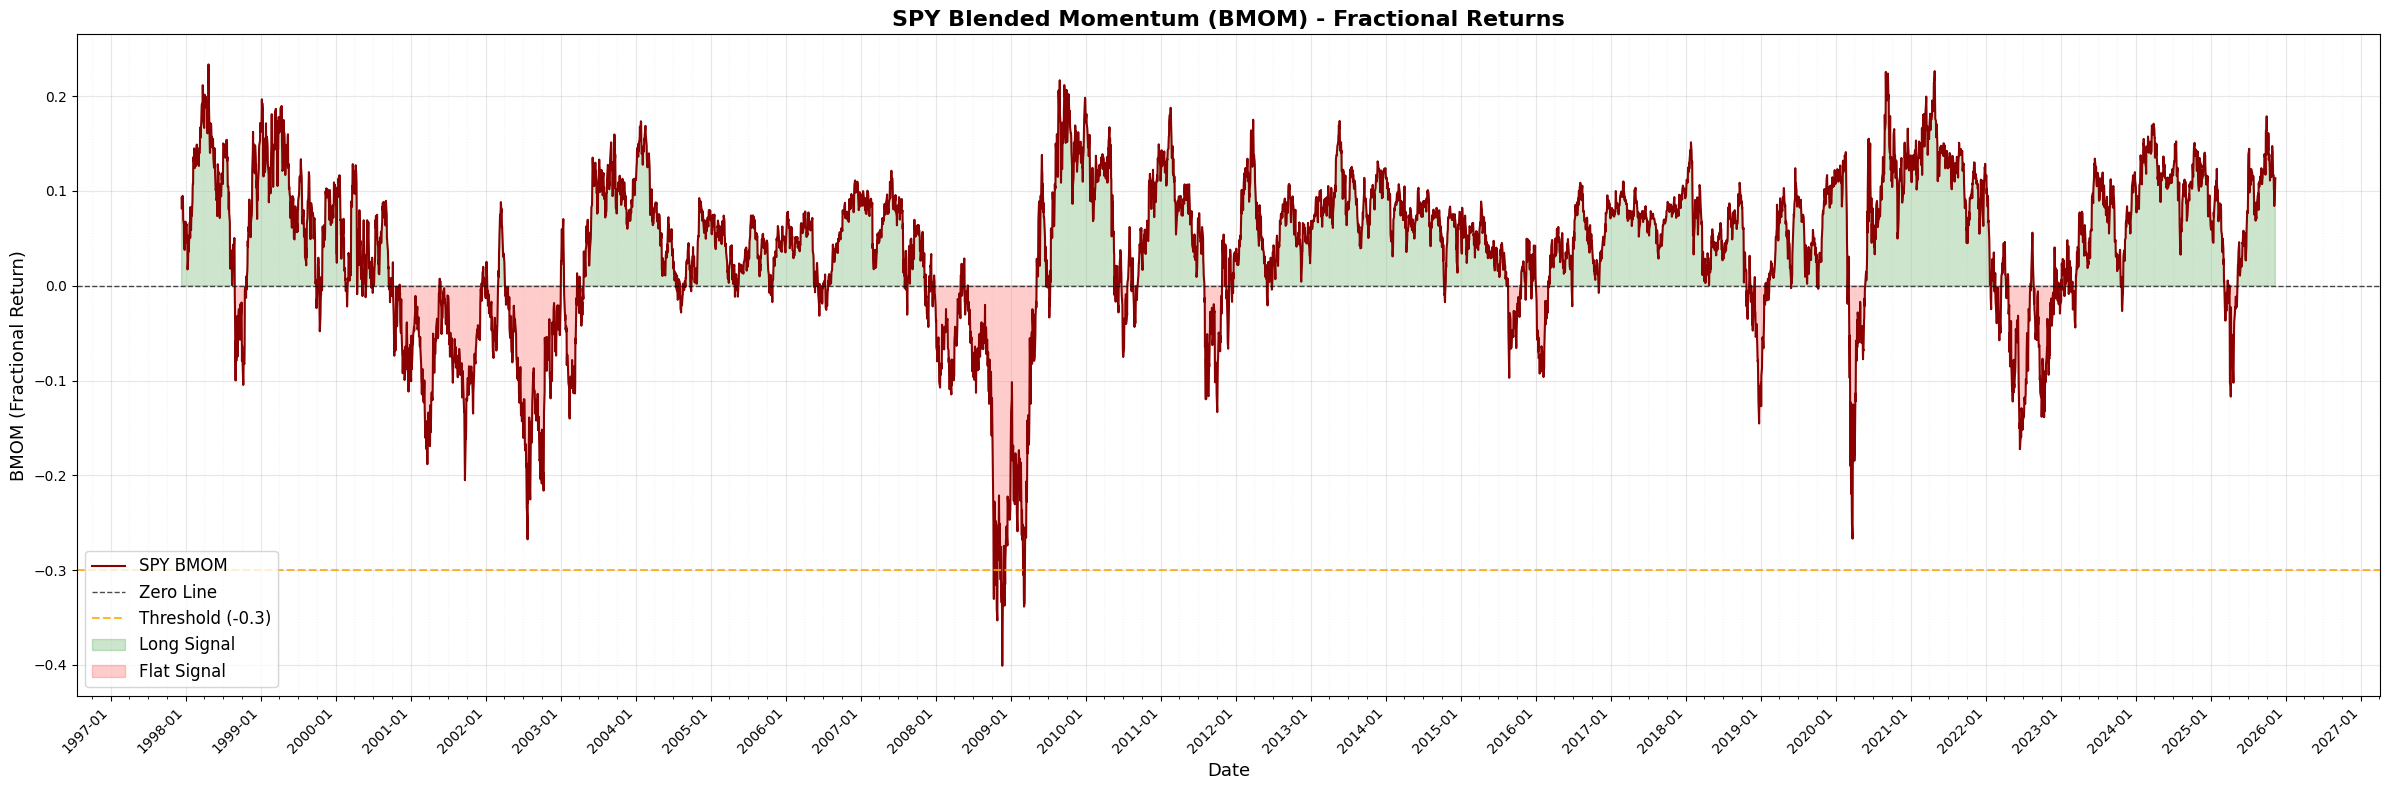


SPY BMOM Range:
  Min: -0.4008 on 2008-11-20
  Max: 0.2334 on 1998-04-21
  Current: 0.1134


In [571]:
# Plot SPY Blended Momentum (BMOM) as fractional returns
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(24, 8))

# Filter to presentation period
spy_bmom_display = df_spy[df_spy.index >= SPY_PRESENTATION_START_DATE]['blended_mom'].copy()

# Plot BMOM
ax.plot(spy_bmom_display.index, spy_bmom_display, linewidth=1.5, color='darkred', label='SPY BMOM')

# Add zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.0, alpha=0.7, label='Zero Line')

# Add threshold line at -0.3
ax.axhline(y=-0.3, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label='Threshold (-0.3)')

# Shade positive/negative regions
ax.fill_between(spy_bmom_display.index, 0, spy_bmom_display, where=(spy_bmom_display > 0), 
                 color='green', alpha=0.2, label='Long Signal')
ax.fill_between(spy_bmom_display.index, 0, spy_bmom_display, where=(spy_bmom_display <= 0), 
                 color='red', alpha=0.2, label='Flat Signal')

# Format x-axis with more dates
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Major tick every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))  # Minor ticks quarterly
plt.xticks(rotation=45, ha='right')

ax.set_title('SPY Blended Momentum (BMOM) - Fractional Returns', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('BMOM (Fractional Return)', fontsize=13)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3, which='major')
ax.grid(True, alpha=0.15, which='minor', linestyle=':')

plt.tight_layout()
plt.show()

print(f"\nSPY BMOM Range:")
print(f"  Min: {spy_bmom_display.min():.4f} on {spy_bmom_display.idxmin().strftime('%Y-%m-%d')}")
print(f"  Max: {spy_bmom_display.max():.4f} on {spy_bmom_display.idxmax().strftime('%Y-%m-%d')}")
print(f"  Current: {spy_bmom_display.iloc[-1]:.4f}")

# H5A4 vs SPY Comparison

Overlay comparison of H5A4 and SPY blended momentum signals

Comparison Period: 1997-12-11 to 2025-11-11


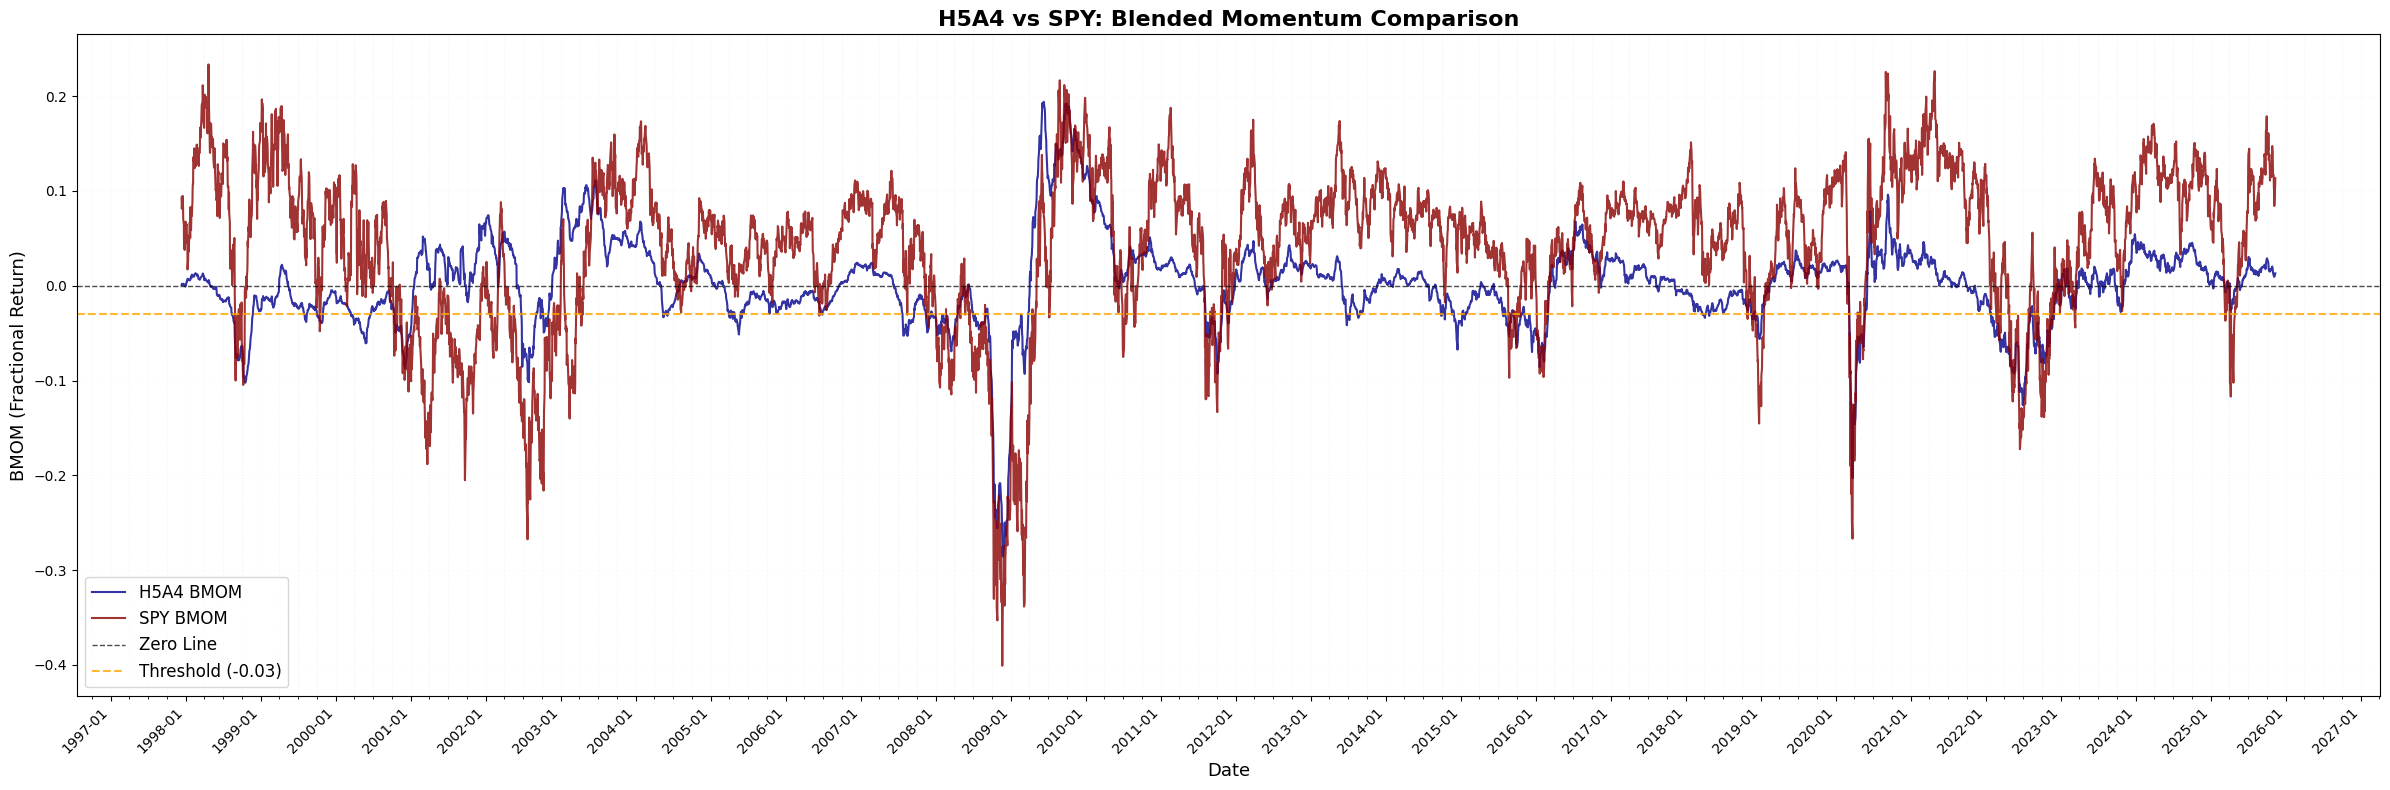


BMOM Correlation (H5A4 vs SPY): 0.5817

BMOM Statistics Comparison:
Metric                       H5A4          SPY
Mean                       0.0014       0.0415
Std Dev                    0.0466       0.0818
Min                       -0.2857      -0.4008
Max                        0.1939       0.2334

Signal Agreement: 63.96%


In [572]:
# Overlay H5A4 and SPY BMOM on the same graph
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(24, 8))

# Find common date range for comparison
# H5A4 starts from PRESENTATION_START_DATE (1997-12-11)
# SPY data starts from 1996-12-31, so we'll use the overlapping period

# Get BMOM data for both
h5a4_bmom = df[df.index >= PRESENTATION_START_DATE]['blended_mom'].copy()
spy_bmom = df_spy[df_spy.index >= SPY_PRESENTATION_START_DATE]['blended_mom'].copy()

# Find common date range
common_start = max(h5a4_bmom.index.min(), spy_bmom.index.min())
common_end = min(h5a4_bmom.index.max(), spy_bmom.index.max())

print(f"Comparison Period: {common_start.strftime('%Y-%m-%d')} to {common_end.strftime('%Y-%m-%d')}")

# Filter to common period
h5a4_bmom_common = h5a4_bmom[(h5a4_bmom.index >= common_start) & (h5a4_bmom.index <= common_end)]
spy_bmom_common = spy_bmom[(spy_bmom.index >= common_start) & (spy_bmom.index <= common_end)]

# Plot both BMOM series
ax.plot(h5a4_bmom_common.index, h5a4_bmom_common, linewidth=1.5, color='darkblue', 
        label='H5A4 BMOM', alpha=0.8)
ax.plot(spy_bmom_common.index, spy_bmom_common, linewidth=1.5, color='darkred', 
        label='SPY BMOM', alpha=0.8)

# Add zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.0, alpha=0.7, label='Zero Line')

# Add threshold line at -0.03
ax.axhline(y=-0.03, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label='Threshold (-0.03)')

# Format x-axis with more dates
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Major tick every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))  # Minor ticks quarterly
plt.xticks(rotation=45, ha='right')

ax.set_title('H5A4 vs SPY: Blended Momentum Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('BMOM (Fractional Return)', fontsize=13)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.03, which='major')
ax.grid(True, alpha=0.15, which='minor', linestyle=':')

plt.tight_layout()
plt.show()

# Align to common index for calculations
common_idx = h5a4_bmom_common.index.intersection(spy_bmom_common.index)
h5a4_aligned = h5a4_bmom_common.reindex(common_idx)
spy_aligned = spy_bmom_common.reindex(common_idx)

# Calculate correlation
correlation = h5a4_aligned.corr(spy_aligned)
print(f"\nBMOM Correlation (H5A4 vs SPY): {correlation:.4f}")

# Summary statistics comparison
print(f"\nBMOM Statistics Comparison:")
print(f"{'Metric':<20} {'H5A4':>12} {'SPY':>12}")
print("="*46)
print(f"{'Mean':<20} {h5a4_aligned.mean():>12.4f} {spy_aligned.mean():>12.4f}")
print(f"{'Std Dev':<20} {h5a4_aligned.std():>12.4f} {spy_aligned.std():>12.4f}")
print(f"{'Min':<20} {h5a4_aligned.min():>12.4f} {spy_aligned.min():>12.4f}")
print(f"{'Max':<20} {h5a4_aligned.max():>12.4f} {spy_aligned.max():>12.4f}")

# Signal agreement
h5a4_signal = (h5a4_aligned > 0).astype(int)
spy_signal = (spy_aligned > 0).astype(int)
agreement = (h5a4_signal == spy_signal).sum() / len(h5a4_signal) * 100
print(f"\nSignal Agreement: {agreement:.2f}%")

# Strategy One - H5A4

Trading strategy for H5A4 based on BMOM threshold crossings

**Logic:**
- If (SPY BMOM[-1] > -0.03 AND SPY BMOM < -0.03 AND H5A4 BMOM < -0.03) OR (H5A4 BMOM[-1] > -0.03 AND SPY BMOM < -0.03 AND H5A4 BMOM < -0.03): signal = 0
- Else if H5A4 BMOM > 0: signal = 1
- Else: signal = previous signal

In [573]:
# Create Strategy One for H5A4
# Align both BMOM series to common index
common_index = h5a4_bmom_common.index.intersection(spy_bmom_common.index)

# Get aligned BMOM values
spy_bmom_strat = spy_bmom_common.reindex(common_index)
h5a4_bmom_strat = h5a4_bmom_common.reindex(common_index)

# Calculate H5A4 mom240 (240-day momentum)
h5a4_mom240 = df['H5A4'].pct_change(240)
h5a4_mom240_strat = h5a4_mom240.reindex(common_index)

# Create strategy dataframe
strategy_one = pd.DataFrame(index=common_index)
strategy_one['H5A4_BMOM'] = h5a4_bmom_strat
strategy_one['SPY_BMOM'] = spy_bmom_strat
strategy_one['H5A4_mom240'] = h5a4_mom240_strat
strategy_one['signal'] = 0  # Initialize all signals to 0

# Implement strategy logic
for i in range(1, len(strategy_one)):
    # Current values
    spy_bmom_curr = strategy_one['SPY_BMOM'].iloc[i]
    h5a4_bmom_curr = strategy_one['H5A4_BMOM'].iloc[i]
    h5a4_mom240_curr = strategy_one['H5A4_mom240'].iloc[i]
    
    # Previous values
    spy_bmom_prev = strategy_one['SPY_BMOM'].iloc[i-1]
    h5a4_bmom_prev = strategy_one['H5A4_BMOM'].iloc[i-1]
    
    # Condition 1: SPY crossed below -0.03 and both are below -0.03
    cond1 = (spy_bmom_prev > -0.03) and (spy_bmom_curr < -0.03) and (h5a4_bmom_curr < -0.03)
    
    # Condition 2: H5A4 crossed below -0.03 and both are below -0.03
    cond2 = (h5a4_bmom_prev > -0.03) and (spy_bmom_curr < -0.03) and (h5a4_bmom_curr < -0.03)
    
    # Additional condition: H5A4 mom240 must be negative
    h5a4_mom240_negative = h5a4_mom240_curr < 0
    
    if (cond1 or cond2) and h5a4_mom240_negative:
        # Set signal to 0 (flat/exit) - only if H5A4 mom240 < 0
        strategy_one['signal'].iloc[i] = 0
    elif h5a4_bmom_curr > 0:
        # Set signal to 1 (long)
        strategy_one['signal'].iloc[i] = 1
    else:
        # Keep previous signal
        strategy_one['signal'].iloc[i] = strategy_one['signal'].iloc[i-1]

print("Strategy One Created!")
print("="*60)
print(f"Period: {strategy_one.index.min().strftime('%Y-%m-%d')} to {strategy_one.index.max().strftime('%Y-%m-%d')}")
print(f"Total days: {len(strategy_one)}")

# Signal distribution
signal_counts = strategy_one['signal'].value_counts().sort_index()
print(f"\nSignal Distribution:")
print(f"  Flat (0): {signal_counts.get(0, 0):>5} ({signal_counts.get(0, 0)/len(strategy_one)*100:>5.1f}%)")
print(f"  Long (1): {signal_counts.get(1, 0):>5} ({signal_counts.get(1, 0)/len(strategy_one)*100:>5.1f}%)")

print(f"\nCurrent signal: {strategy_one['signal'].iloc[-1]}")
print(f"\nLast 10 signals:")
strategy_one[['H5A4_BMOM', 'SPY_BMOM', 'H5A4_mom240', 'signal']].head(50)

Strategy One Created!
Period: 1997-12-11 to 2025-11-11
Total days: 7023

Signal Distribution:
  Flat (0):  1448 ( 20.6%)
  Long (1):  5575 ( 79.4%)

Current signal: 1

Last 10 signals:


,H5A4_BMOM,SPY_BMOM,H5A4_mom240,signal
Date,,,,
1997-12-11,0.000927,0.092849,0.016702,0
1997-12-12,0.001689,0.081186,0.018218,1
1997-12-15,0.001192,0.089258,0.017820,1
1997-12-16,0.001881,0.094740,0.019042,1
1997-12-17,0.001421,0.087853,0.019157,1
1997-12-18,0.001969,0.083727,0.019661,1
1997-12-19,0.002102,0.069902,0.018942,1
1997-12-22,0.001381,0.064660,0.019771,1
1997-12-23,0.000317,0.040356,0.019171,1


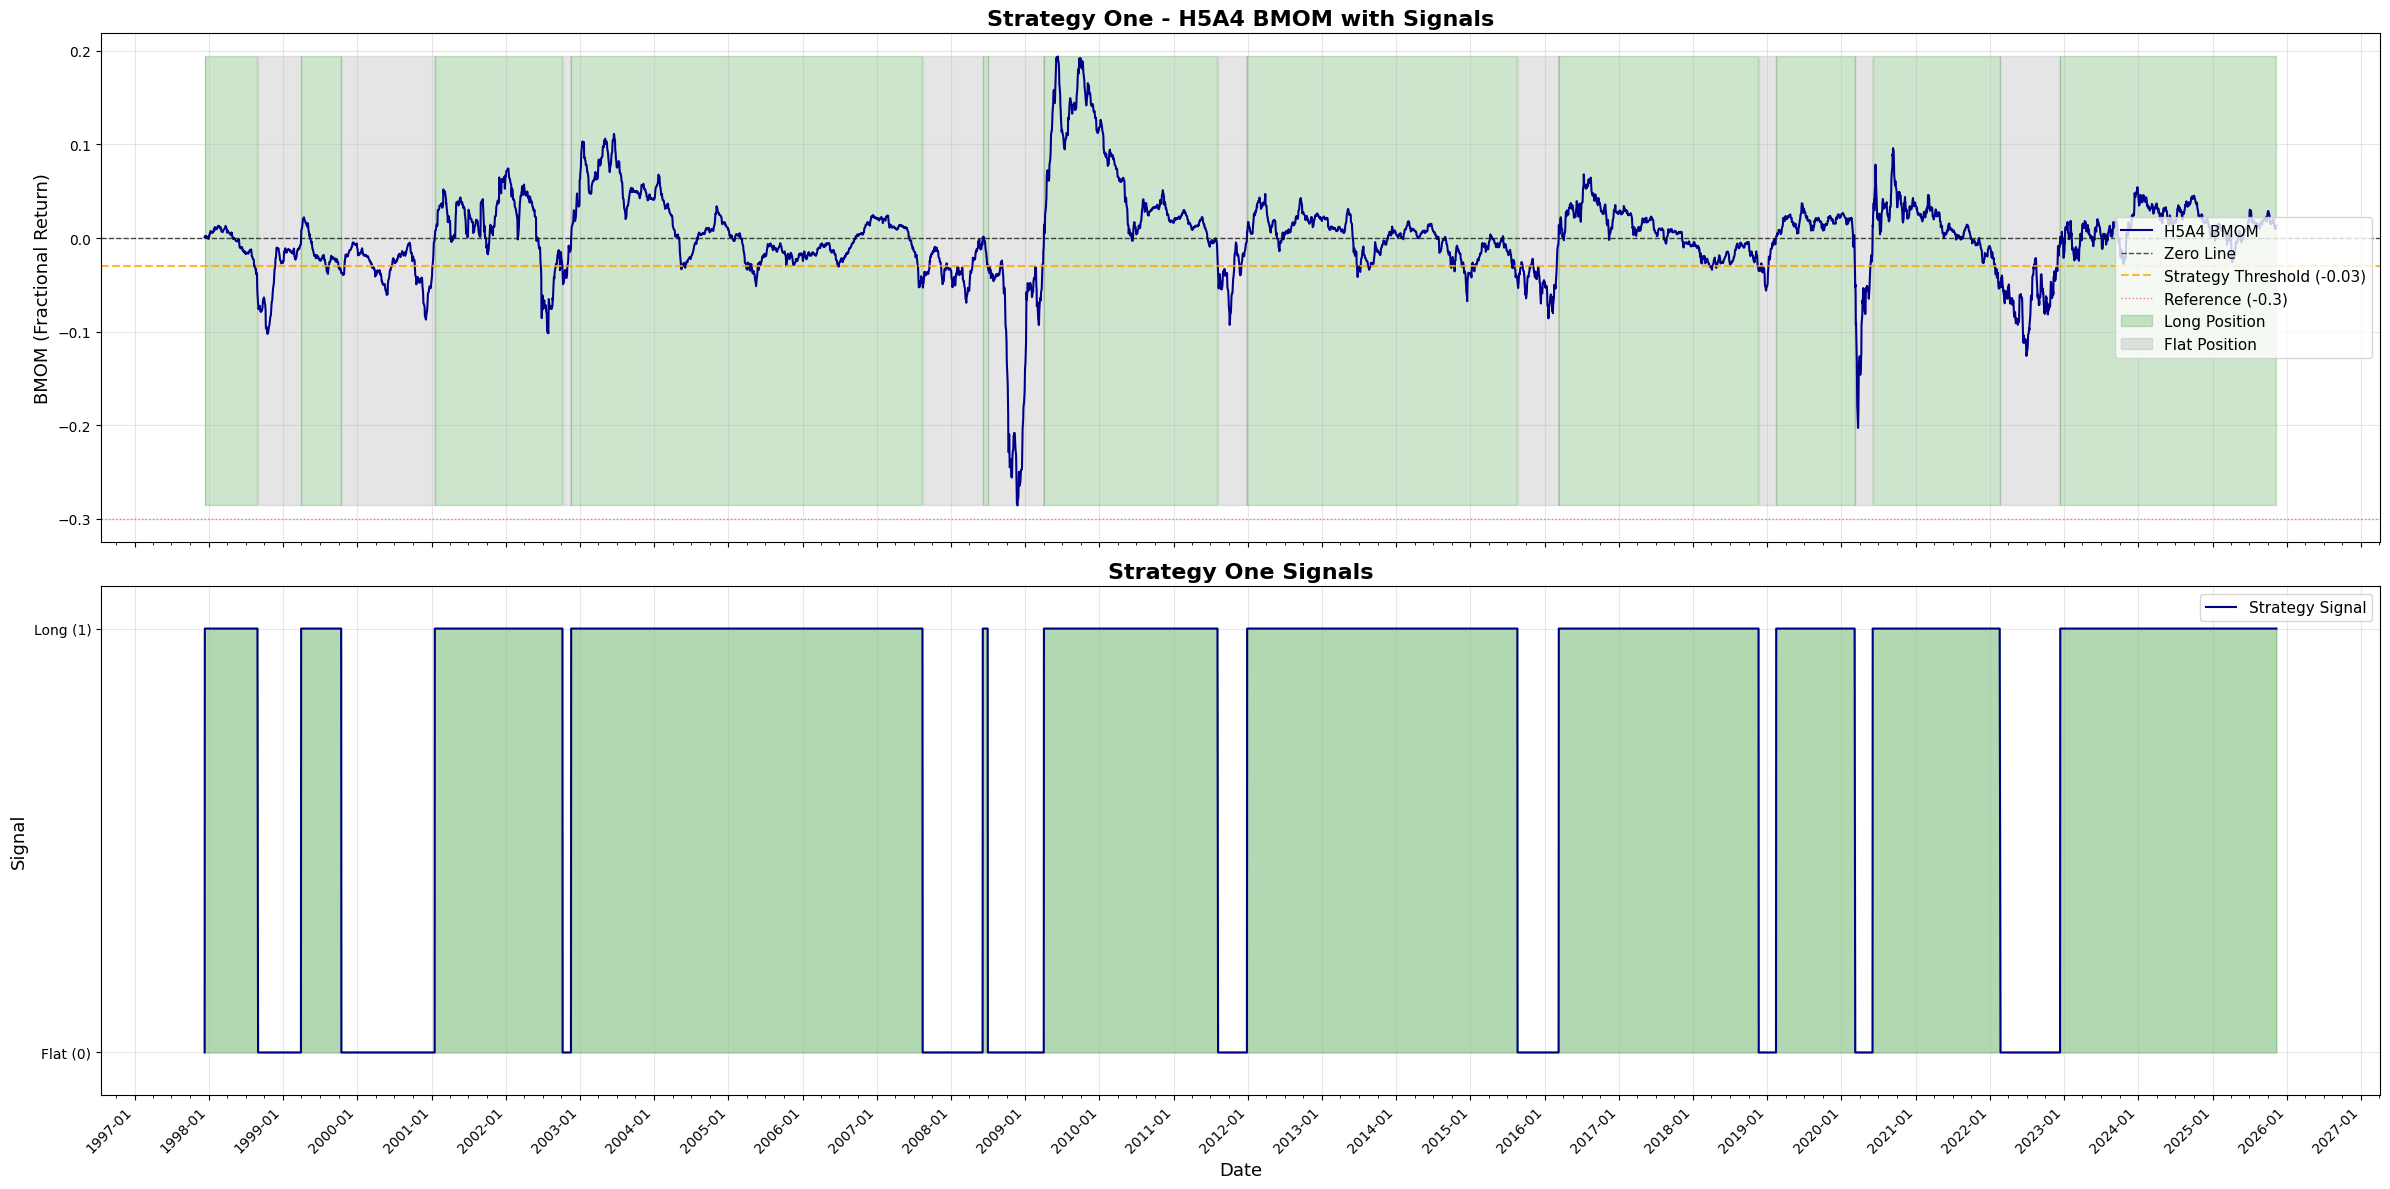

In [574]:
# Visualize Strategy One signals with H5A4 BMOM
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12), sharex=True)

# Top panel: H5A4 BMOM with threshold lines
ax1.plot(strategy_one.index, strategy_one['H5A4_BMOM'], linewidth=1.5, color='darkblue', label='H5A4 BMOM')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.0, alpha=0.7, label='Zero Line')
ax1.axhline(y=-0.03, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label='Strategy Threshold (-0.03)')
ax1.axhline(y=-0.3, color='red', linestyle=':', linewidth=1.0, alpha=0.5, label='Reference (-0.3)')

# Shade based on signal
long_mask = strategy_one['signal'] == 1
flat_mask = strategy_one['signal'] == 0

ax1.fill_between(strategy_one.index, strategy_one['H5A4_BMOM'].min(), strategy_one['H5A4_BMOM'].max(),
                  where=long_mask, alpha=0.2, color='green', label='Long Position')
ax1.fill_between(strategy_one.index, strategy_one['H5A4_BMOM'].min(), strategy_one['H5A4_BMOM'].max(),
                  where=flat_mask, alpha=0.2, color='gray', label='Flat Position')

ax1.set_title('Strategy One - H5A4 BMOM with Signals', fontsize=16, fontweight='bold')
ax1.set_ylabel('BMOM (Fractional Return)', fontsize=13)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom panel: Strategy signals
ax2.plot(strategy_one.index, strategy_one['signal'], linewidth=1.5, color='navy', label='Strategy Signal')
ax2.fill_between(strategy_one.index, 0, strategy_one['signal'], alpha=0.3, color='green')
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Flat (0)', 'Long (1)'])

# Format x-axis with more dates
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
plt.xticks(rotation=45, ha='right')

ax2.set_title('Strategy One Signals', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=13)
ax2.set_ylabel('Signal', fontsize=13)
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Strategy One Performance:
Period: 1997-12-11 to 2025-11-11
Total days: 7023
Days invested (Long): 5574 (79.4%)
Days flat: 1449 (20.6%)

Strategy Returns:
  Total Return: 27.37%
  Annualized Return: 0.87%
  Annualized Volatility: 3.57%
  Sharpe Ratio: 0.26

Buy-and-Hold Returns:
  Total Return: -1.74%
  Annualized Return: -0.06%
  Annualized Volatility: 5.14%
  Sharpe Ratio: 0.01

Outperformance:
  Total: 29.11%
  Annualized: 0.93%


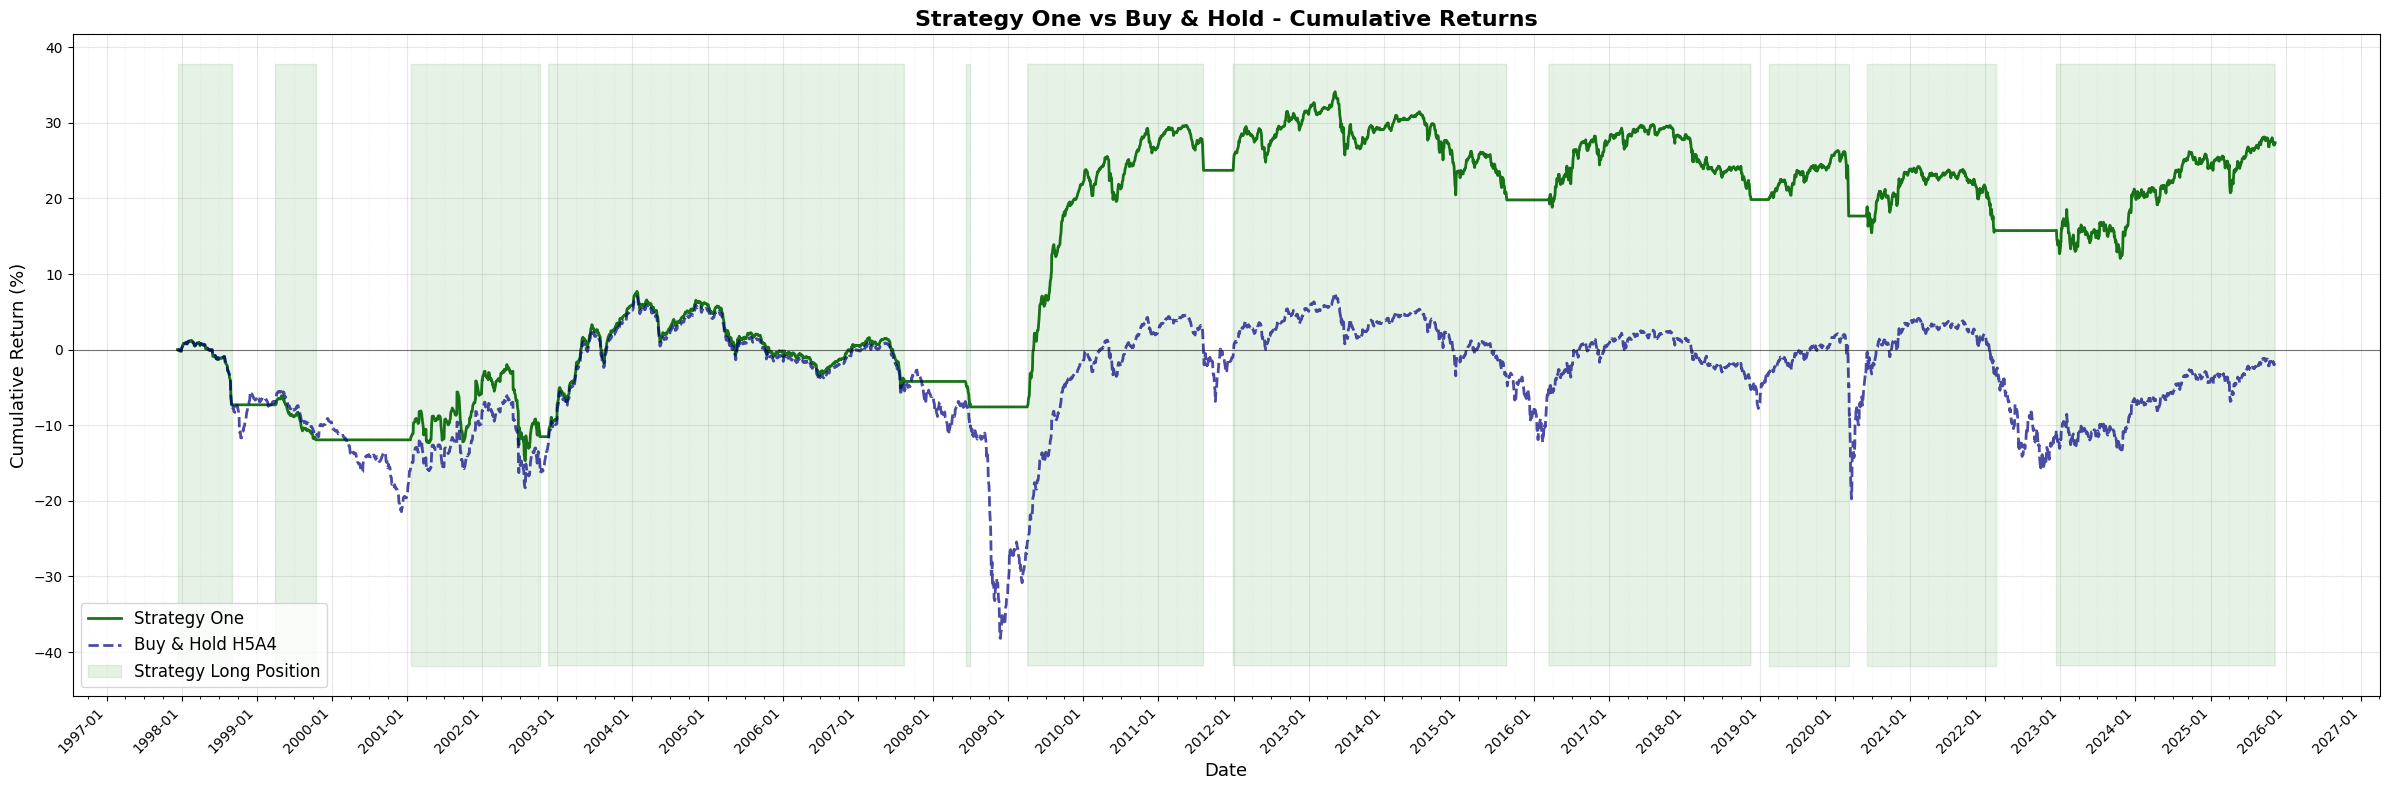

In [575]:
# Calculate and Plot Strategy One Equity Curve
# Get H5A4 prices aligned with strategy
h5a4_prices = df['H5A4'].reindex(strategy_one.index)

# Calculate daily returns
daily_returns = h5a4_prices.pct_change()

# Calculate strategy returns (use PREVIOUS day's signal for today's returns)
strategy_one['daily_return'] = daily_returns * strategy_one['signal'].shift(1)
strategy_one['daily_return'] = strategy_one['daily_return'].fillna(0)  # First day has no previous signal
strategy_one['cumulative_return'] = (1 + strategy_one['daily_return']).cumprod() - 1

# Calculate buy-and-hold returns for comparison
strategy_one['bah_cumulative_return'] = (1 + daily_returns).cumprod() - 1

# Performance metrics
total_days = len(strategy_one)
days_invested = (strategy_one['signal'].shift(1).fillna(0) == 1).sum()  # Count based on actual positions held
investment_pct = days_invested / total_days * 100

print("Strategy One Performance:")
print("="*60)
print(f"Period: {strategy_one.index.min().strftime('%Y-%m-%d')} to {strategy_one.index.max().strftime('%Y-%m-%d')}")
print(f"Total days: {total_days}")
print(f"Days invested (Long): {days_invested} ({investment_pct:.1f}%)")
print(f"Days flat: {total_days - days_invested} ({100-investment_pct:.1f}%)")

print(f"\nStrategy Returns:")
print(f"  Total Return: {strategy_one['cumulative_return'].iloc[-1]:.2%}")
print(f"  Annualized Return: {(1 + strategy_one['cumulative_return'].iloc[-1]) ** (252 / total_days) - 1:.2%}")
print(f"  Annualized Volatility: {strategy_one['daily_return'].std() * np.sqrt(252):.2%}")
print(f"  Sharpe Ratio: {(strategy_one['daily_return'].mean() / strategy_one['daily_return'].std()) * np.sqrt(252):.2f}")

print(f"\nBuy-and-Hold Returns:")
print(f"  Total Return: {strategy_one['bah_cumulative_return'].iloc[-1]:.2%}")
print(f"  Annualized Return: {(1 + strategy_one['bah_cumulative_return'].iloc[-1]) ** (252 / total_days) - 1:.2%}")
print(f"  Annualized Volatility: {daily_returns.std() * np.sqrt(252):.2%}")
print(f"  Sharpe Ratio: {(daily_returns.mean() / daily_returns.std()) * np.sqrt(252):.2f}")

print(f"\nOutperformance:")
print(f"  Total: {(strategy_one['cumulative_return'].iloc[-1] - strategy_one['bah_cumulative_return'].iloc[-1]):.2%}")
print(f"  Annualized: {((1 + strategy_one['cumulative_return'].iloc[-1]) ** (252 / total_days) - 1) - ((1 + strategy_one['bah_cumulative_return'].iloc[-1]) ** (252 / total_days) - 1):.2%}")

# Plot equity curve
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(24, 8))

# Plot equity curves
ax.plot(strategy_one.index, strategy_one['cumulative_return'] * 100, 
        linewidth=2.0, color='darkgreen', label='Strategy One', alpha=0.9)
ax.plot(strategy_one.index, strategy_one['bah_cumulative_return'] * 100, 
        linewidth=2.0, color='navy', label='Buy & Hold H5A4', alpha=0.7, linestyle='--')

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Shade periods when strategy is invested (using lagged signal)
long_mask = strategy_one['signal'].shift(1).fillna(0) == 1
ax.fill_between(strategy_one.index, ax.get_ylim()[0], ax.get_ylim()[1],
                 where=long_mask, alpha=0.1, color='green', label='Strategy Long Position')

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
plt.xticks(rotation=45, ha='right')

ax.set_title('Strategy One vs Buy & Hold - Cumulative Returns', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Cumulative Return (%)', fontsize=13)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3, which='major')
ax.grid(True, alpha=0.15, which='minor', linestyle=':')

plt.tight_layout()
plt.show()

# Strategy Two - Drawdown Differential Override

Modifies Strategy 1 by overriding to always be long H5A4 when drawdown differential exceeds threshold

**Logic:**
- drawdiffthresh = 0.10
- If (Strat1 drawdown - H5A4 drawdown) > 0.10: signal = 1 (force long H5A4)
- Otherwise: Use Strategy 1 signals (0 or 1)

In [576]:
# Create Strategy Two with Drawdown Differential Override
drawdiffthresh = 0.1

# Calculate drawdowns for Strategy 1 equity curve
strat1_equity = 1 + strategy_one['cumulative_return']
strat1_running_max = strat1_equity.expanding().max()
strat1_drawdown = (strat1_equity - strat1_running_max) / strat1_running_max

# Calculate drawdowns for H5A4 buy-and-hold
h5a4_equity = 1 + strategy_one['bah_cumulative_return']
h5a4_running_max = h5a4_equity.expanding().max()
h5a4_drawdown = (h5a4_equity - h5a4_running_max) / h5a4_running_max

# Calculate drawdown differential
drawdown_diff = strat1_drawdown - h5a4_drawdown

# Create Strategy Two dataframe
strategy_two = strategy_one.copy()
strategy_two['strat1_dd'] = strat1_drawdown
strategy_two['h5a4_dd'] = h5a4_drawdown
strategy_two['dd_diff'] = drawdown_diff
strategy_two['signal_strat2'] = strategy_one['signal'].copy()

# Apply Strategy Two logic
for i in range(len(strategy_two)):
    if drawdown_diff.iloc[i] > drawdiffthresh:
        # Force long H5A4
        strategy_two['signal_strat2'].iloc[i + 1] = 1
    # Otherwise keep Strategy 1 signal (already copied)

# Calculate Strategy Two returns (use PREVIOUS day's signal for today's returns)
strategy_two['daily_return_strat2'] = daily_returns * strategy_two['signal_strat2'].shift(1)
strategy_two['daily_return_strat2'] = strategy_two['daily_return_strat2'].fillna(0)  # First day has no previous signal
strategy_two['cumulative_return_strat2'] = (1 + strategy_two['daily_return_strat2']).cumprod() - 1

print("Strategy Two Created!")
print("="*60)
print(f"Drawdown Difference Threshold: {drawdiffthresh:.2%}")

# Count override periods
override_count = (drawdown_diff > drawdiffthresh).sum()
override_pct = override_count / len(strategy_two) * 100
print(f"\nOverride periods (dd_diff > {drawdiffthresh:.2%}): {override_count} days ({override_pct:.1f}%)")

# Signal distribution for Strategy Two (using lagged signal for actual positions)
signal_counts_s2_lagged = strategy_two['signal_strat2'].shift(1).fillna(0).value_counts().sort_index()
print(f"\nStrategy Two Signal Distribution (actual positions held):")
print(f"  Flat (0): {signal_counts_s2_lagged.get(0.0, 0):>5.0f} ({signal_counts_s2_lagged.get(0.0, 0)/len(strategy_two)*100:>5.1f}%)")
print(f"  Long (1): {signal_counts_s2_lagged.get(1.0, 0):>5.0f} ({signal_counts_s2_lagged.get(1.0, 0)/len(strategy_two)*100:>5.1f}%)")

# Performance comparison
print(f"\nPerformance Comparison:")
print(f"{'Metric':<25} {'Strat 1':>12} {'Strat 2':>12}")
print("="*51)
print(f"{'Total Return':<25} {strategy_two['cumulative_return'].iloc[-1]:>11.2%} {strategy_two['cumulative_return_strat2'].iloc[-1]:>11.2%}")

s1_ann = (1 + strategy_two['cumulative_return'].iloc[-1]) ** (252 / len(strategy_two)) - 1
s2_ann = (1 + strategy_two['cumulative_return_strat2'].iloc[-1]) ** (252 / len(strategy_two)) - 1
print(f"{'Annualized Return':<25} {s1_ann:>11.2%} {s2_ann:>11.2%}")

s1_vol = strategy_two['daily_return'].std() * np.sqrt(252)
s2_vol = strategy_two['daily_return_strat2'].std() * np.sqrt(252)
print(f"{'Annualized Volatility':<25} {s1_vol:>11.2%} {s2_vol:>11.2%}")

s1_sharpe = (strategy_two['daily_return'].mean() / strategy_two['daily_return'].std()) * np.sqrt(252)
s2_sharpe = (strategy_two['daily_return_strat2'].mean() / strategy_two['daily_return_strat2'].std()) * np.sqrt(252)
print(f"{'Sharpe Ratio':<25} {s1_sharpe:>11.2f} {s2_sharpe:>11.2f}")

print(f"\nCurrent signals:")
print(f"  Strategy One: {strategy_two['signal'].iloc[-1]}")
print(f"  Strategy Two: {strategy_two['signal_strat2'].iloc[-1]}")
print(f"  Drawdown Diff: {strategy_two['dd_diff'].iloc[-1]:.4f}")

Strategy Two Created!
Drawdown Difference Threshold: 10.00%

Override periods (dd_diff > 10.00%): 274 days (3.9%)

Strategy Two Signal Distribution (actual positions held):
  Flat (0):  1318 ( 18.8%)
  Long (1):  5705 ( 81.2%)

Performance Comparison:
Metric                         Strat 1      Strat 2
Total Return                   27.37%      26.64%
Annualized Return               0.87%       0.85%
Annualized Volatility           3.57%       4.24%
Sharpe Ratio                     0.26        0.22

Current signals:
  Strategy One: 1
  Strategy Two: 1
  Drawdown Diff: 0.0354


Strategy Two Created!
Drawdown Difference Threshold: 10.00%

Override periods (dd_diff > 10.00%): 274 days (3.9%)

Strategy Two Signal Distribution (actual positions held):
  Flat (0):  1318 ( 18.8%)
  Long (1):  5705 ( 81.2%)

Performance Comparison:
Metric                         Strat 1      Strat 2
Total Return                   27.37%      26.64%
Annualized Return               0.87%       0.85%
Annualized Volatility           3.57%       4.24%
Sharpe Ratio                     0.26        0.22

Current signals:
  Strategy One: 1
  Strategy Two: 1
  Drawdown Diff: 0.0354


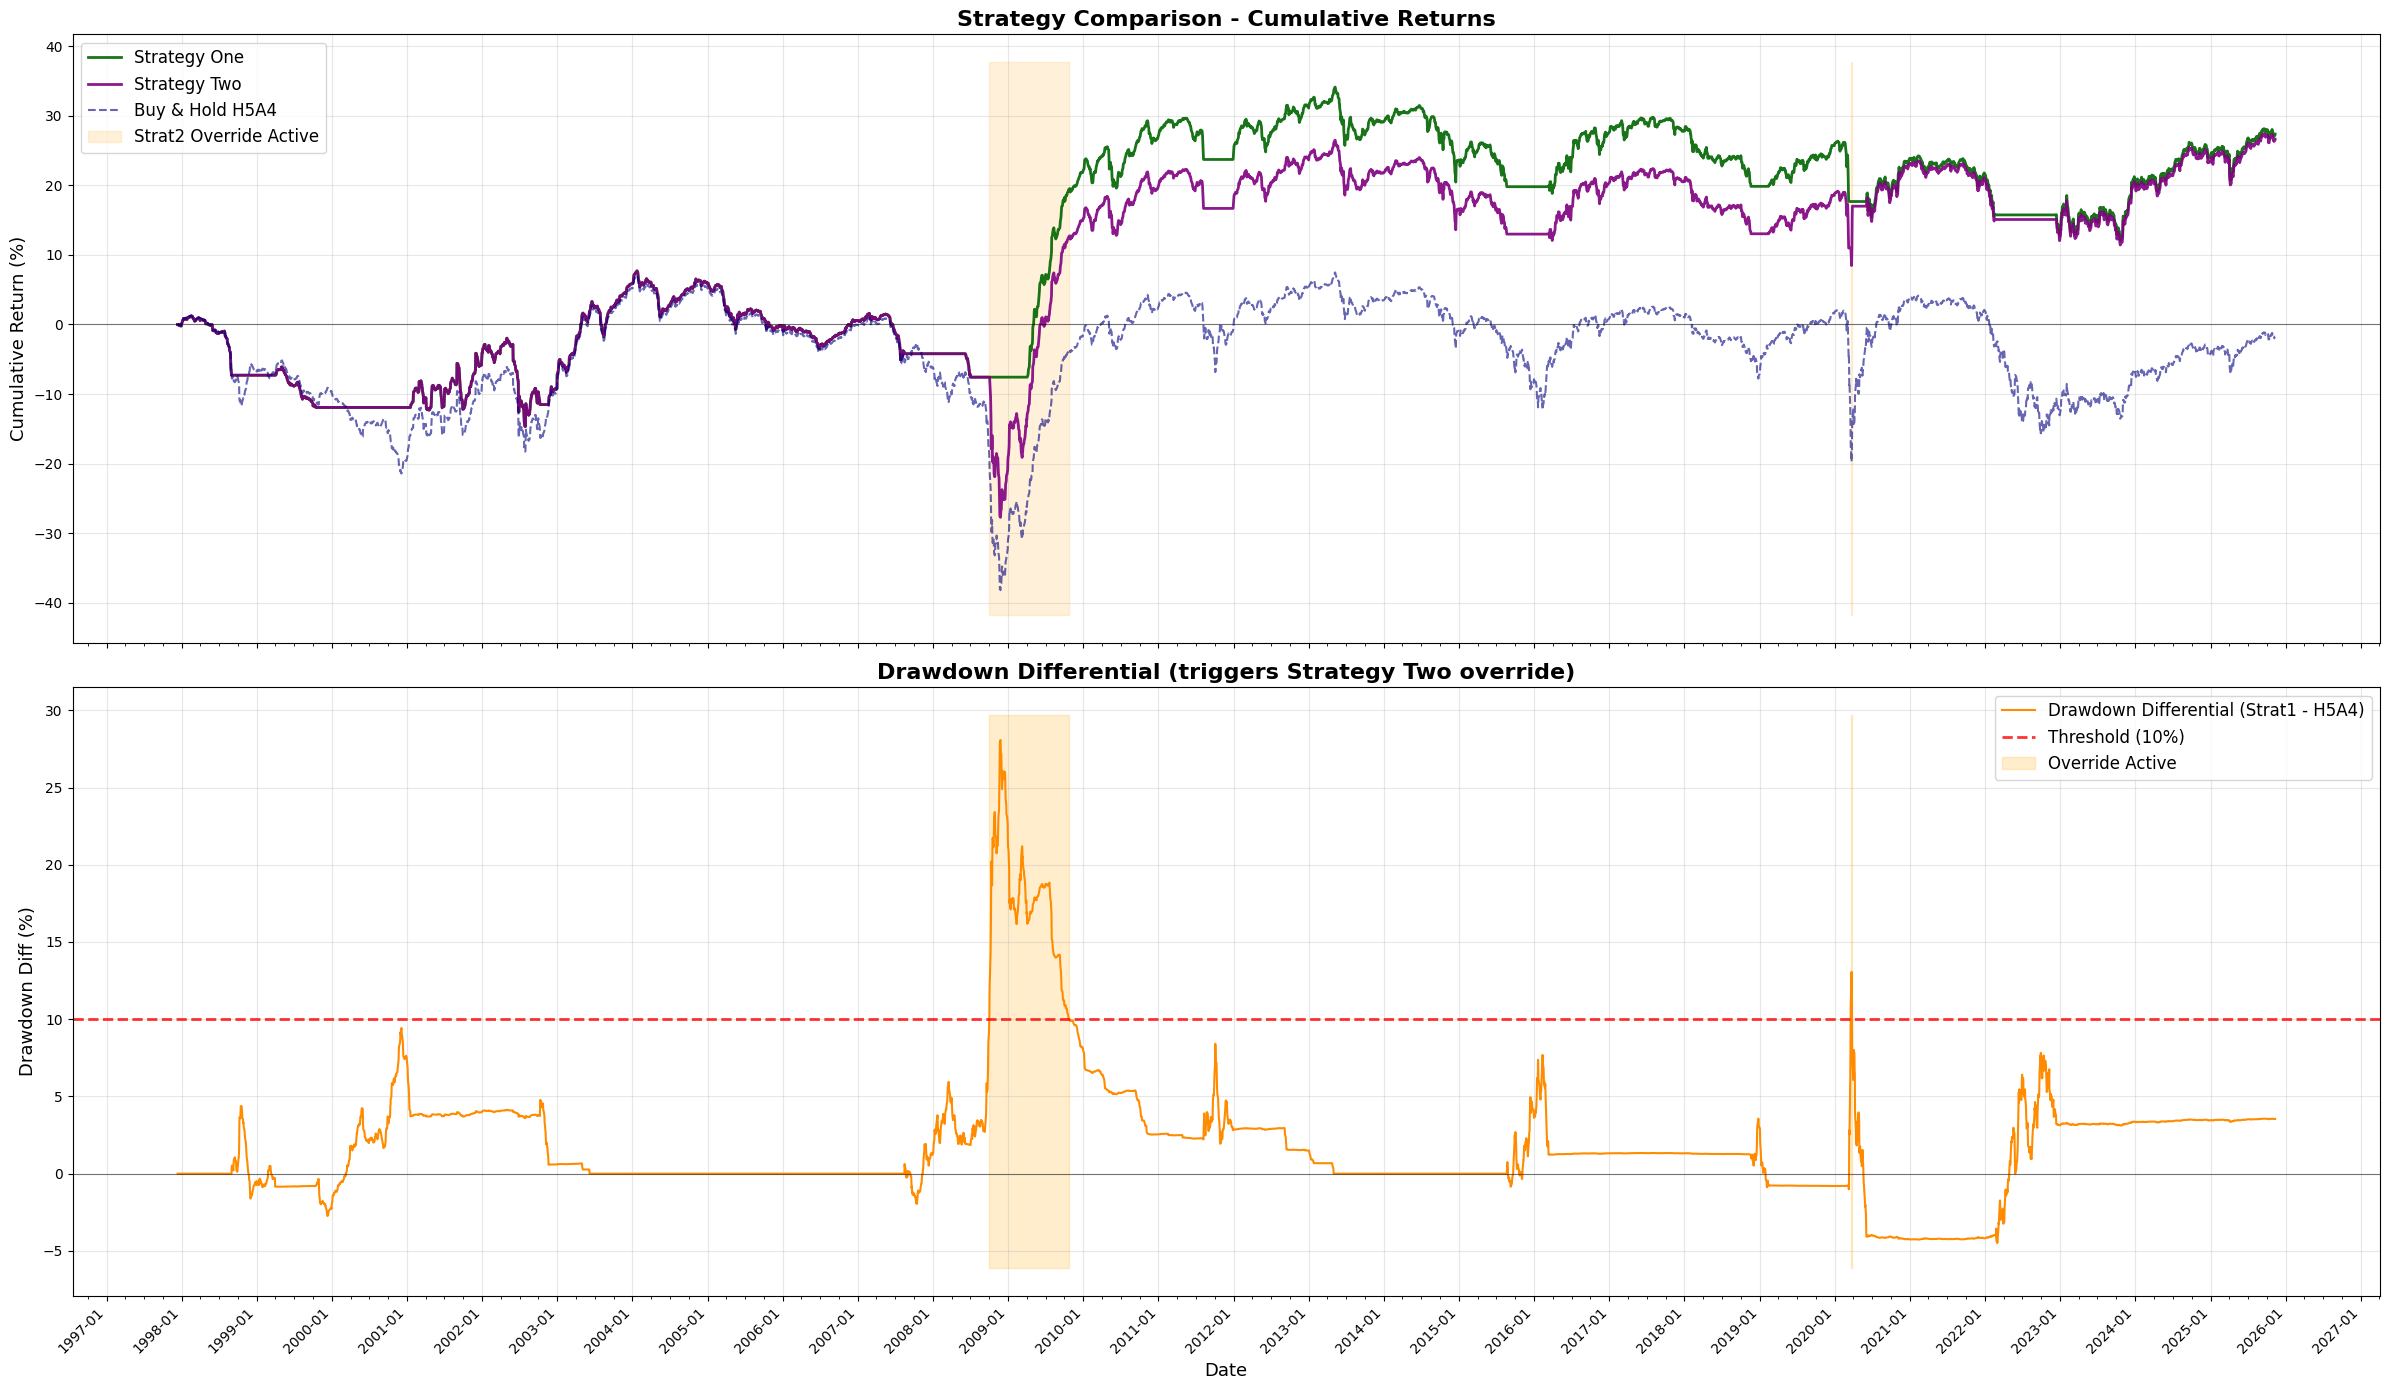


Final Performance Summary:
Strategy                Total Return     Ann. Return     Sharpe
Strategy One                 27.37%          0.87%      0.26
Strategy Two                 26.64%          0.85%      0.22
Buy & Hold H5A4              -1.74%         -0.06%      0.01


In [577]:
print("Strategy Two Created!")
print("="*60)
print(f"Drawdown Difference Threshold: {drawdiffthresh:.2%}")

# Count override periods
override_count = (drawdown_diff > drawdiffthresh).sum()
override_pct = override_count / len(strategy_two) * 100
print(f"\nOverride periods (dd_diff > {drawdiffthresh:.2%}): {override_count} days ({override_pct:.1f}%)")

# Signal distribution for Strategy Two (using lagged signal for actual positions)
signal_counts_s2_lagged = strategy_two['signal_strat2'].shift(1).fillna(0).value_counts().sort_index()
print(f"\nStrategy Two Signal Distribution (actual positions held):")
print(f"  Flat (0): {signal_counts_s2_lagged.get(0.0, 0):>5.0f} ({signal_counts_s2_lagged.get(0.0, 0)/len(strategy_two)*100:>5.1f}%)")
print(f"  Long (1): {signal_counts_s2_lagged.get(1.0, 0):>5.0f} ({signal_counts_s2_lagged.get(1.0, 0)/len(strategy_two)*100:>5.1f}%)")

# Performance comparison
print(f"\nPerformance Comparison:")
print(f"{'Metric':<25} {'Strat 1':>12} {'Strat 2':>12}")
print("="*51)
print(f"{'Total Return':<25} {strategy_two['cumulative_return'].iloc[-1]:>11.2%} {strategy_two['cumulative_return_strat2'].iloc[-1]:>11.2%}")

s1_ann = (1 + strategy_two['cumulative_return'].iloc[-1]) ** (252 / len(strategy_two)) - 1
s2_ann = (1 + strategy_two['cumulative_return_strat2'].iloc[-1]) ** (252 / len(strategy_two)) - 1
print(f"{'Annualized Return':<25} {s1_ann:>11.2%} {s2_ann:>11.2%}")

s1_vol = strategy_two['daily_return'].std() * np.sqrt(252)
s2_vol = strategy_two['daily_return_strat2'].std() * np.sqrt(252)
print(f"{'Annualized Volatility':<25} {s1_vol:>11.2%} {s2_vol:>11.2%}")

s1_sharpe = (strategy_two['daily_return'].mean() / strategy_two['daily_return'].std()) * np.sqrt(252)
s2_sharpe = (strategy_two['daily_return_strat2'].mean() / strategy_two['daily_return_strat2'].std()) * np.sqrt(252)
print(f"{'Sharpe Ratio':<25} {s1_sharpe:>11.2f} {s2_sharpe:>11.2f}")

print(f"\nCurrent signals:")
print(f"  Strategy One: {strategy_two['signal'].iloc[-1]}")
print(f"  Strategy Two: {strategy_two['signal_strat2'].iloc[-1]}")
print(f"  Drawdown Diff: {strategy_two['dd_diff'].iloc[-1]:.4f}")

# Overlay Strategy 1 and Strategy 2 Equity Curves
import matplotlib.dates as mdates

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 14), sharex=True)

# Top panel: Equity curves comparison
ax1.plot(strategy_two.index, strategy_two['cumulative_return'] * 100, 
         linewidth=2.0, color='darkgreen', label='Strategy One', alpha=0.9)
ax1.plot(strategy_two.index, strategy_two['cumulative_return_strat2'] * 100, 
         linewidth=2.0, color='purple', label='Strategy Two', alpha=0.9)
ax1.plot(strategy_two.index, strategy_two['bah_cumulative_return'] * 100, 
         linewidth=1.5, color='navy', label='Buy & Hold H5A4', alpha=0.6, linestyle='--')

# Add zero line
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Highlight override periods
override_mask = strategy_two['dd_diff'] > drawdiffthresh
if override_mask.any():
    ax1.fill_between(strategy_two.index, ax1.get_ylim()[0], ax1.get_ylim()[1],
                     where=override_mask, alpha=0.15, color='orange', label='Strat2 Override Active')

ax1.set_title('Strategy Comparison - Cumulative Returns', fontsize=16, fontweight='bold')
ax1.set_ylabel('Cumulative Return (%)', fontsize=13)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True, alpha=0.3)

# Bottom panel: Drawdown differential
ax2.plot(strategy_two.index, strategy_two['dd_diff'] * 100, 
         linewidth=1.5, color='darkorange', label='Drawdown Differential (Strat1 - H5A4)')
ax2.axhline(y=drawdiffthresh * 100, color='red', linestyle='--', linewidth=2.0, 
            alpha=0.8, label=f'Threshold ({drawdiffthresh:.0%})')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Shade override periods
ax2.fill_between(strategy_two.index, ax2.get_ylim()[0], ax2.get_ylim()[1],
                 where=override_mask, alpha=0.2, color='orange', label='Override Active')

# Format x-axis
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
plt.xticks(rotation=45, ha='right')

ax2.set_title('Drawdown Differential (triggers Strategy Two override)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=13)
ax2.set_ylabel('Drawdown Diff (%)', fontsize=13)
ax2.legend(loc='best', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nFinal Performance Summary:")
print(f"{'Strategy':<20} {'Total Return':>15} {'Ann. Return':>15} {'Sharpe':>10}")
print("="*65)
print(f"{'Strategy One':<20} {strategy_two['cumulative_return'].iloc[-1]:>14.2%} {s1_ann:>14.2%} {s1_sharpe:>9.2f}")
print(f"{'Strategy Two':<20} {strategy_two['cumulative_return_strat2'].iloc[-1]:>14.2%} {s2_ann:>14.2%} {s2_sharpe:>9.2f}")
print(f"{'Buy & Hold H5A4':<20} {strategy_two['bah_cumulative_return'].iloc[-1]:>14.2%} {(1 + strategy_two['bah_cumulative_return'].iloc[-1]) ** (252 / len(strategy_two)) - 1:>14.2%} {(daily_returns.mean() / daily_returns.std()) * np.sqrt(252):>9.2f}")

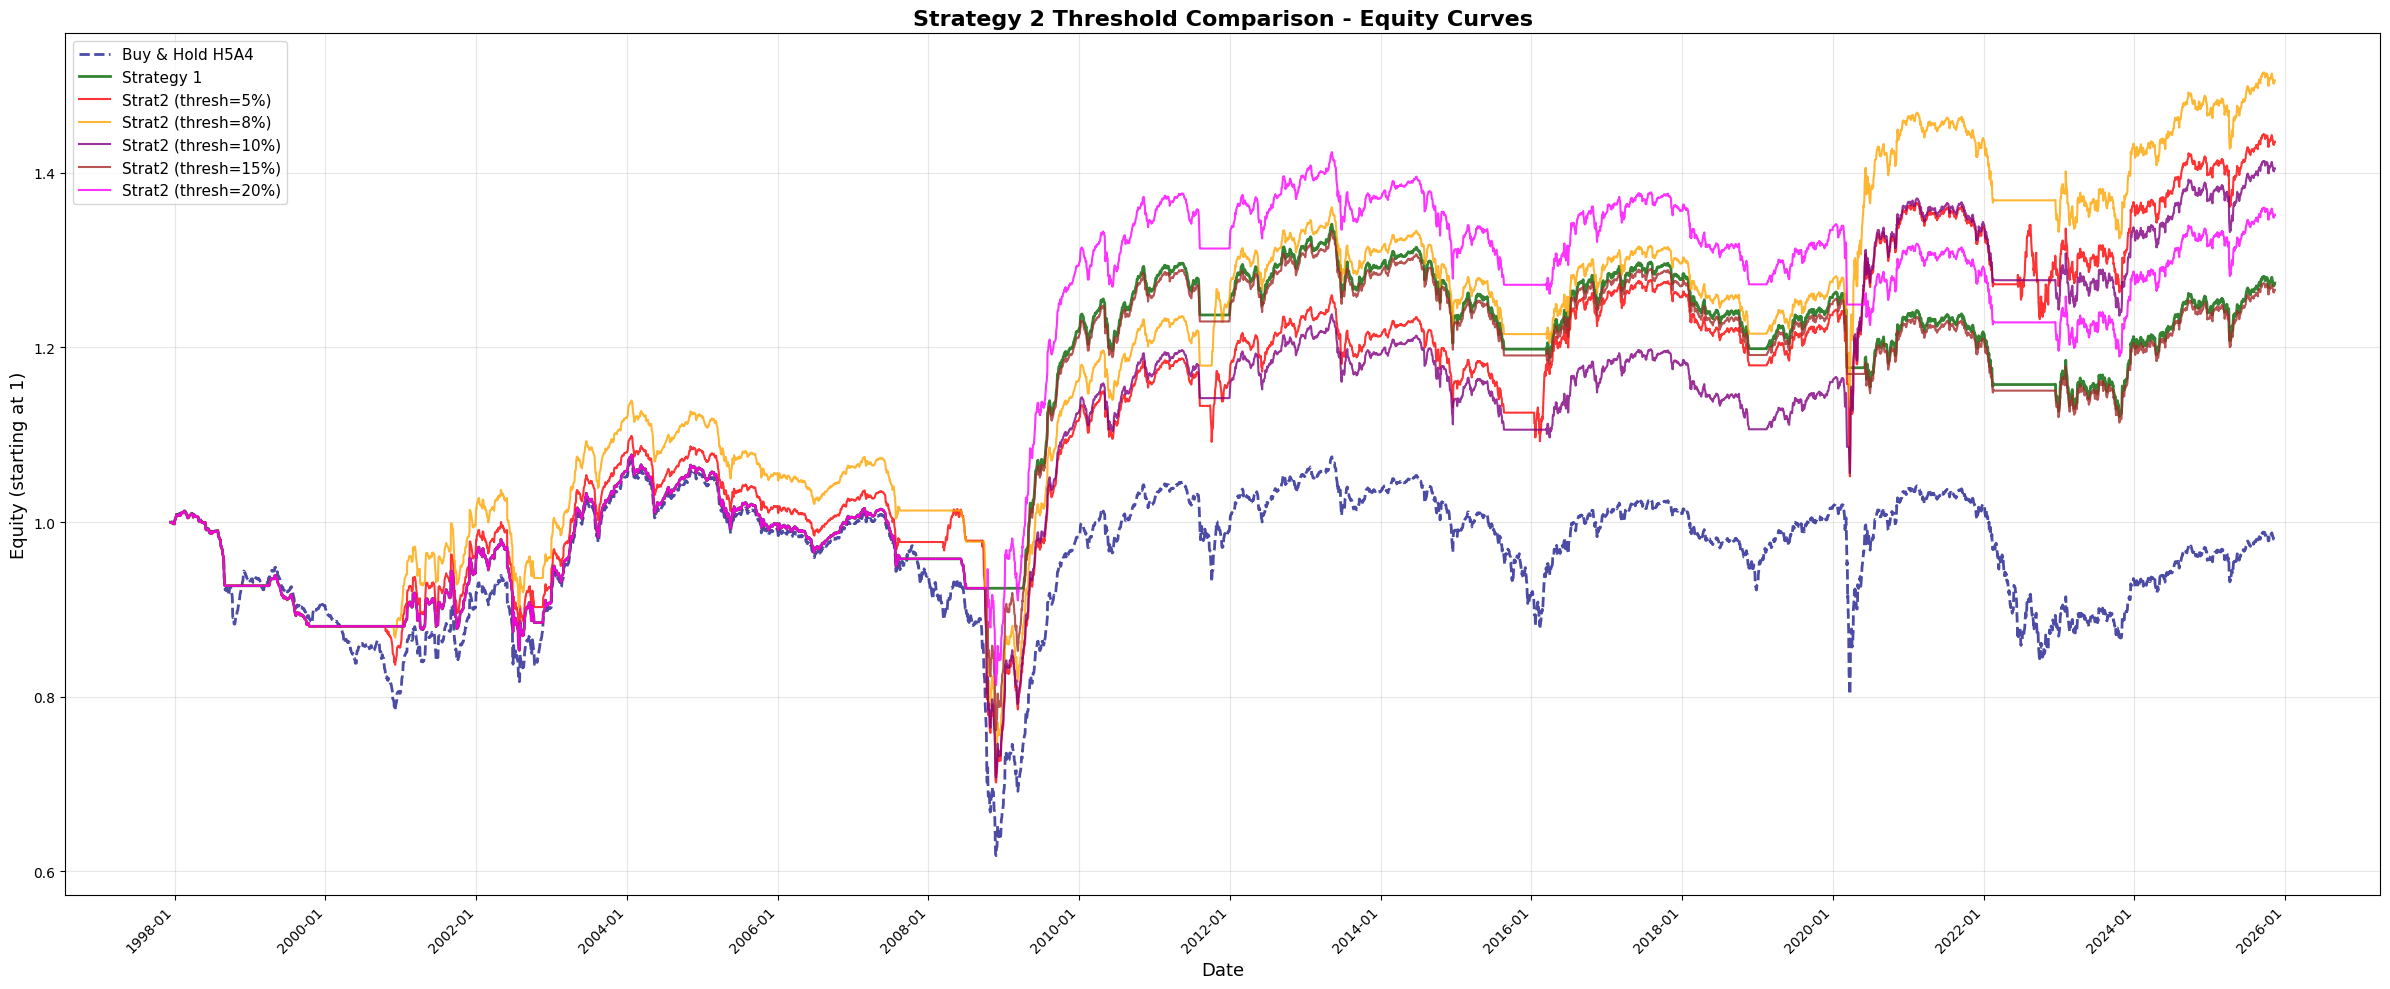


Performance Summary by Threshold:
Strategy                    Ann Return   Volatility     Sharpe
----------------------------------------------------------------------
Buy & Hold                     -0.06%       5.14%      0.01
Strategy 1                      0.87%       3.57%      0.26
Strat2 (thresh=5%)              1.31%       4.76%      0.30
Strat2 (thresh=8%)              1.48%       4.47%      0.35
Strat2 (thresh=10%)             1.23%       4.40%      0.30
Strat2 (thresh=15%)             0.85%       4.11%      0.23
Strat2 (thresh=20%)             1.09%       3.99%      0.29

✓ Exported to H5A4_Strat2_Threshold_Analysis.xlsx
Sheets: Signals_Equity, Metrics
Date range: 1997-12-11 00:00:00 to 2025-11-11 00:00:00


In [578]:
# Test Strategy 2 at multiple thresholds
thresholds = [0.05, 0.08, 0.10, 0.15, 0.20]

# Store results for each threshold
strat2_results = {}

for thresh in thresholds:
    # Create signals for this threshold
    signals = strategy_one['signal'].copy()
    
    # Track override state
    in_override = False
    
    # Apply drawdown differential override with exit condition
    for i in range(len(strategy_one)):
        strat1_sig = strategy_one['signal'].iloc[i]
        dd_diff_val = drawdown_diff.iloc[i]
        
        # Entry: dd_diff > threshold (override to long)
        if dd_diff_val > thresh:
            signals.iloc[i] = 1
            in_override = True
        # Exit: Strategy 1 signal returns to 1
        elif in_override and strat1_sig == 1:
            signals.iloc[i] = strat1_sig
            in_override = False
        # Otherwise: maintain override or follow Strategy 1
        elif in_override:
            signals.iloc[i] = 1  # Stay long during override
        else:
            signals.iloc[i] = strat1_sig  # Follow Strategy 1
    
    # Calculate returns (use previous day's signal)
    returns = daily_returns * signals.shift(1)
    returns = returns.fillna(0)
    cumulative = (1 + returns).cumprod()
    
    # Store results
    strat2_results[thresh] = {
        'signal': signals,
        'returns': returns,
        'equity': cumulative,
        'ann_return': cumulative.iloc[-1] ** (252 / len(cumulative)) - 1,
        'volatility': returns.std() * np.sqrt(252),
        'sharpe': (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    }

# Calculate benchmark and Strat1 equity (starting at 1)
benchmark_equity = (1 + daily_returns).cumprod()
strat1_equity_curve = (1 + strategy_one['daily_return']).cumprod()

# Plot all equity curves
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(24, 10))

# Plot benchmark
ax.plot(strategy_one.index, benchmark_equity, linewidth=2.0, color='navy', 
        label='Buy & Hold H5A4', linestyle='--', alpha=0.7)

# Plot Strategy 1
ax.plot(strategy_one.index, strat1_equity_curve, linewidth=2.0, color='darkgreen', 
        label='Strategy 1', alpha=0.8)

# Plot each Strategy 2 threshold
colors = ['red', 'orange', 'purple', 'brown', 'magenta']
for i, thresh in enumerate(thresholds):
    ax.plot(strategy_one.index, strat2_results[thresh]['equity'], 
            linewidth=1.5, color=colors[i], 
            label=f'Strat2 (thresh={thresh:.0%})', alpha=0.8)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

ax.set_title('Strategy 2 Threshold Comparison - Equity Curves', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Equity (starting at 1)', fontsize=13)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance summary table
print("\nPerformance Summary by Threshold:")
print("="*70)
print(f"{'Strategy':<25} {'Ann Return':>12} {'Volatility':>12} {'Sharpe':>10}")
print("-"*70)

# Benchmark
bm_ann = benchmark_equity.iloc[-1] ** (252 / len(benchmark_equity)) - 1
bm_vol = daily_returns.std() * np.sqrt(252)
bm_sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
print(f"{'Buy & Hold':<25} {bm_ann:>11.2%} {bm_vol:>11.2%} {bm_sharpe:>9.2f}")

# Strategy 1
s1_ann_ret = strat1_equity_curve.iloc[-1] ** (252 / len(strat1_equity_curve)) - 1
print(f"{'Strategy 1':<25} {s1_ann_ret:>11.2%} {s1_vol:>11.2%} {s1_sharpe:>9.2f}")

# Strategy 2 variants
for thresh in thresholds:
    r = strat2_results[thresh]
    print(f"{'Strat2 (thresh=' + f'{thresh:.0%}' + ')':<25} {r['ann_return']:>11.2%} {r['volatility']:>11.2%} {r['sharpe']:>9.2f}")

# Export to Excel - Use strategy_one index to ensure proper alignment
export_signals = pd.DataFrame(index=strategy_one.index)
export_signals.index.name = 'Date'

# Add BMOM values
export_signals['H5A4_BMOM'] = strategy_one['H5A4_BMOM']
export_signals['SPY_BMOM'] = strategy_one['SPY_BMOM']

# Add drawdown differential
export_signals['DD_Diff'] = drawdown_diff

# Add Strategy 1 signal (already aligned by index)
export_signals['Strat1_Signal'] = strategy_one['signal']

# Add Strategy 2 signals for each threshold (already aligned by index)
for thresh in thresholds:
    col_name = f'Strat2_{int(thresh*100):02d}_Signal'
    export_signals[col_name] = strat2_results[thresh]['signal']

# Add equity curves
export_signals['Benchmark_Equity'] = benchmark_equity
export_signals['Strat1_Equity'] = strat1_equity_curve
for thresh in thresholds:
    col_name = f'Strat2_{int(thresh*100):02d}_Equity'
    export_signals[col_name] = strat2_results[thresh]['equity']

# Create metrics summary
metrics_data = {
    'Strategy': ['Buy & Hold', 'Strategy 1'] + [f'Strat2 (thresh={t:.0%})' for t in thresholds],
    'Ann_Return': [bm_ann, s1_ann_ret] + [strat2_results[t]['ann_return'] for t in thresholds],
    'Volatility': [bm_vol, s1_vol] + [strat2_results[t]['volatility'] for t in thresholds],
    'Sharpe': [bm_sharpe, s1_sharpe] + [strat2_results[t]['sharpe'] for t in thresholds]
}
metrics_df = pd.DataFrame(metrics_data)

# Export to Excel
output_file = 'H5A4_Strat2_Threshold_Analysis.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    export_signals.to_excel(writer, sheet_name='Signals_Equity')
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)

print(f"\n✓ Exported to {output_file}")
print(f"Sheets: Signals_Equity, Metrics")
print(f"Date range: {export_signals.index.min()} to {export_signals.index.max()}")

# Export to Excel

Export all strategy data and metrics to Excel file

In [579]:
# Create comprehensive data export
export_df = pd.DataFrame(index=strategy_two.index)

# SPY data - normalize to start at 1.0
spy_cumret_full = df_spy['cumulative_return'].reindex(strategy_two.index)
spy_equity_curve = (1 + spy_cumret_full) / (1 + spy_cumret_full.iloc[0])  # Normalize to 1.0 at start
export_df['SPY_Equity'] = spy_equity_curve
export_df['SPY_BMOM'] = df_spy['blended_mom'].reindex(strategy_two.index)
export_df['SPY_Mom240'] = df_spy['return_240d'].reindex(strategy_two.index)

# H5A4 basic data
export_df['H5A4_Mom240'] = df['return_240d'].reindex(strategy_two.index)
export_df['H5A4_Returns'] = daily_returns
export_df['H5A4_Drawdown'] = strategy_two['h5a4_dd']
export_df['H5A4_BMOM'] = strategy_two['H5A4_BMOM']
export_df['H5A4_Equity'] = h5a4_equity  # Buy-and-hold equity
export_df['H5A4_Price'] = h5a4_prices

# Strategy 1 data - normalize equity to start at 1.0 on 1997-12-12
strat1_equity_normalized = strat1_equity / strat1_equity.loc['1997-12-12']
export_df['Strat1_Signal'] = strategy_two['signal']
export_df['Strat1_Return'] = strategy_two['daily_return']
export_df['Strat1_Equity'] = strat1_equity_normalized
export_df['Strat1_Drawdown'] = strategy_two['strat1_dd']
export_df['Strat1_DD_Differential'] = strategy_two['dd_diff']  # Strat1 DD - H5A4 DD

# Strategy 2 data
export_df['Strat2_Signal'] = strategy_two['signal_strat2']
export_df['Strat2_Return'] = strategy_two['daily_return_strat2']
export_df['Strat2_Equity'] = 1 + strategy_two['cumulative_return_strat2']

# Export to Excel
output_filename = 'Taiya_Shiva_Bond_TAA_Stats_Visual.xlsx'
output_path = output_filename

# Try to install openpyxl if not available
try:
    import openpyxl
except ImportError:
    print("Installing openpyxl...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'openpyxl', '-q'])
    import openpyxl
    print("openpyxl installed successfully!")

# Write to Excel with formatting
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    export_df.to_excel(writer, sheet_name='Strategy_Data')
    
    # Create summary sheet
    summary_data = {
        'Metric': [
            'Period Start', 'Period End', 'Total Days',
            '',
            'Strategy One - Total Return', 'Strategy One - Annualized Return', 
            'Strategy One - Volatility', 'Strategy One - Sharpe Ratio',
            'Strategy One - Days Long', 'Strategy One - Days Flat',
            '',
            'Strategy Two - Total Return', 'Strategy Two - Annualized Return',
            'Strategy Two - Volatility', 'Strategy Two - Sharpe Ratio',
            'Strategy Two - Days Long', 'Strategy Two - Days Flat',
            'Strategy Two - Override Days',
            '',
            'Buy & Hold - Total Return', 'Buy & Hold - Annualized Return',
            'Buy & Hold - Volatility', 'Buy & Hold - Sharpe Ratio'
        ],
        'Value': [
            strategy_two.index.min().strftime('%Y-%m-%d'),
            strategy_two.index.max().strftime('%Y-%m-%d'),
            len(strategy_two),
            '',
            f"{strategy_two['cumulative_return'].iloc[-1]:.4f}",
            f"{s1_ann:.4f}",
            f"{s1_vol:.4f}",
            f"{s1_sharpe:.4f}",
            (strategy_two['signal'] == 1).sum(),
            (strategy_two['signal'] == 0).sum(),
            '',
            f"{strategy_two['cumulative_return_strat2'].iloc[-1]:.4f}",
            f"{s2_ann:.4f}",
            f"{s2_vol:.4f}",
            f"{s2_sharpe:.4f}",
            (strategy_two['signal_strat2'] == 1).sum(),
            (strategy_two['signal_strat2'] == 0).sum(),
            (strategy_two['dd_diff'] > drawdiffthresh).sum(),
            '',
            f"{strategy_two['bah_cumulative_return'].iloc[-1]:.4f}",
            f"{(1 + strategy_two['bah_cumulative_return'].iloc[-1]) ** (252 / len(strategy_two)) - 1:.4f}",
            f"{daily_returns.std() * np.sqrt(252):.4f}",
            f"{(daily_returns.mean() / daily_returns.std()) * np.sqrt(252):.4f}"
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"✓ Data exported successfully!")
print(f"File: {output_path}")
print(f"Sheets: Strategy_Data, Summary")
print(f"\nColumns exported ({len(export_df.columns)}):")
for col in export_df.columns:
    print(f"  - {col}")
print(f"\nRows: {len(export_df)}")
print(f"Date range: {export_df.index.min().strftime('%Y-%m-%d')} to {export_df.index.max().strftime('%Y-%m-%d')}")

✓ Data exported successfully!
File: Taiya_Shiva_Bond_TAA_Stats_Visual.xlsx
Sheets: Strategy_Data, Summary

Columns exported (17):
  - SPY_Equity
  - SPY_BMOM
  - SPY_Mom240
  - H5A4_Mom240
  - H5A4_Returns
  - H5A4_Drawdown
  - H5A4_BMOM
  - H5A4_Equity
  - H5A4_Price
  - Strat1_Signal
  - Strat1_Return
  - Strat1_Equity
  - Strat1_Drawdown
  - Strat1_DD_Differential
  - Strat2_Signal
  - Strat2_Return
  - Strat2_Equity

Rows: 7023
Date range: 1997-12-11 to 2025-11-11


In [583]:
# Export all signals to Excel (H5A4, G502, C5A4) with H5A4 price

# Start with H5A4 signals and price
signals_export = pd.DataFrame(index=strategy_two.index)
signals_export.index.name = 'Date'
signals_export['H5A4_Strat1_Signal'] = strategy_two['signal']
signals_export['H5A4_Strat2_Signal'] = strategy_two['signal_strat2']
signals_export['H5A4_Price'] = df['H5A4'].reindex(signals_export.index)

# Load G502 signals from TLT_G502_Analysis.xlsx
try:
    g502_data = pd.read_excel('TLT_G502_Analysis.xlsx', sheet_name='Strategy_Data', index_col='Date', parse_dates=True)
    signals_export['G502_Strat1_Signal'] = g502_data['Strat1_Signal'].reindex(signals_export.index)
    signals_export['G502_Strat2_Signal'] = g502_data['Strat2_Signal'].reindex(signals_export.index)
    print("G502 signals loaded from TLT_G502_Analysis.xlsx")
except Exception as e:
    print(f"Warning: Could not load G502 signals: {e}")
    signals_export['G502_Strat1_Signal'] = None
    signals_export['G502_Strat2_Signal'] = None

# Load C5A4 signals from LQD_C5A4_Analysis.xlsx
try:
    c5a4_data = pd.read_excel('LQD_C5A4_Analysis.xlsx', sheet_name='Strategy_Data', index_col='Date', parse_dates=True)
    signals_export['C5A4_Strat1_Signal'] = c5a4_data['Strat1_Signal'].reindex(signals_export.index)
    signals_export['C5A4_Strat2_Signal'] = c5a4_data['Strat2_Signal'].reindex(signals_export.index)
    print("C5A4 signals loaded from LQD_C5A4_Analysis.xlsx")
except Exception as e:
    print(f"Warning: Could not load C5A4 signals: {e}")
    signals_export['C5A4_Strat1_Signal'] = None
    signals_export['C5A4_Strat2_Signal'] = None

# Export to Excel
signals_filename = 'H5A4_Signals.xlsx'

with pd.ExcelWriter(signals_filename, engine='openpyxl') as writer:
    signals_export.to_excel(writer, sheet_name='Signals')

print(f"\nSignals exported to {signals_filename}")
print(f"Columns: {signals_export.columns.tolist()}")
print(f"Rows: {len(signals_export)}")
print(f"Date range: {signals_export.index.min().strftime('%Y-%m-%d')} to {signals_export.index.max().strftime('%Y-%m-%d')}")


Signals exported to H5A4_Signals.xlsx
Columns: ['H5A4_Strat1_Signal', 'H5A4_Strat2_Signal', 'H5A4_Price', 'G502_Strat1_Signal', 'G502_Strat2_Signal', 'C5A4_Strat1_Signal', 'C5A4_Strat2_Signal']
Rows: 7023
Date range: 1997-12-11 to 2025-11-11


In [584]:
print("Indices match:", strategy_one.index.equals(strategy_two.index))
print("Lengths:", len(strategy_one), len(strategy_two))

Indices match: True
Lengths: 7023 7023


In [585]:
date = '1998-08-27'
print(f"\nOn {date}:")
print(f"  strategy_one['signal']: {strategy_one.loc[date, 'signal']}")
print(f"  Strat2_10 in results: {strat2_results[0.10]['signal'].loc[date]}")


On 1998-08-27:
  strategy_one['signal']: 1.0
  Strat2_10 in results: 1
